# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [11]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier

import seaborn as sns
import warnings

from scipy.stats import zscore



# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)


Using device: cpu


In [2]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [3]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [4]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [9]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_3_repeatibility/processed/'

# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df.head()

,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,1.098767,0.000012,REF_1
1,100.0,0.854596,0.244176,REF_1
2,100.0,0.976682,0.610411,REF_1
3,100.0,1.709193,-0.244164,REF_1
4,100.0,-0.122085,-0.488341,REF_1


## Balance Dataset

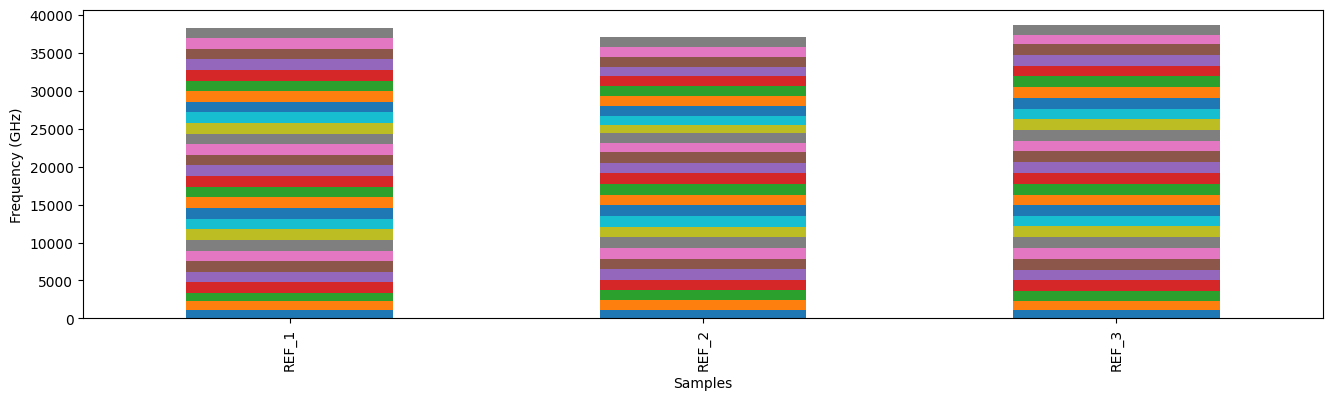

Mode value: 1412


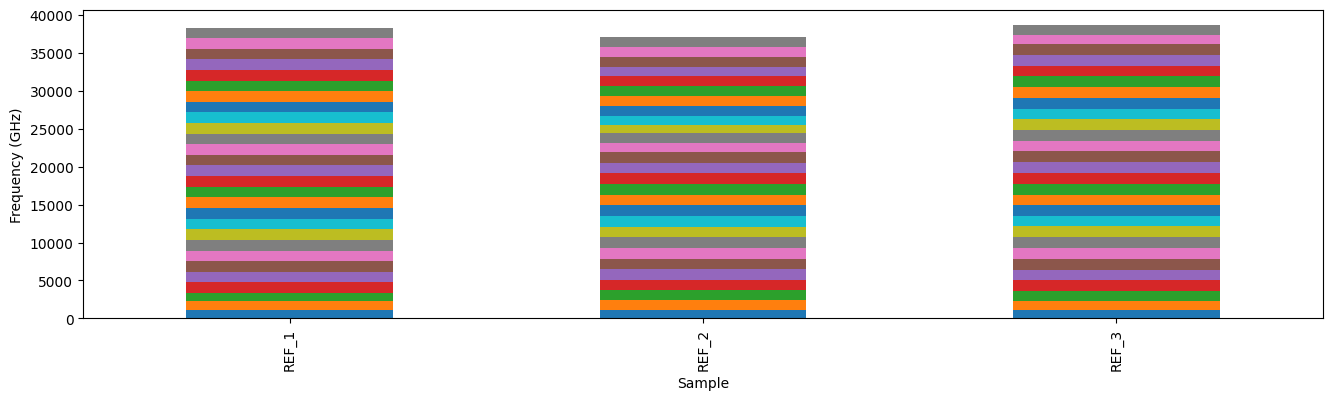

In [19]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
#no legend
bx.get_legend().remove()
plt.show()

# Balance the data by taking the mode of samples per frequency
mode = df.groupby(['Sample', 'Frequency (GHz)']).size().mode()[0]
print(f'Mode value: {mode}')
mode = 2350

# Function to reduce samples to the mode value
def reduce_to_mode(df, sample, frequency, mode):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mode, sample down to the mode
    if len(freq_df) > mode:
        return freq_df.sample(n=mode, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mode(df, sample, frequency, mode))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#remove legend
bx.get_legend().remove()
plt.show()

## Sample a test set

In [ ]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.25
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42)
# train_set, test_set = train_test_split(df_balanced, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set


## Data Distribution per frequency and Sample

   Frequency (GHz)   LG (mV)   HG (mV) Sample
0            100.0  1.098767  0.000012  REF_1
1            100.0  0.854596  0.244176  REF_1
2            100.0  0.976682  0.610411  REF_1
3            100.0  1.709193 -0.244164  REF_1
4            100.0 -0.122085 -0.488341  REF_1


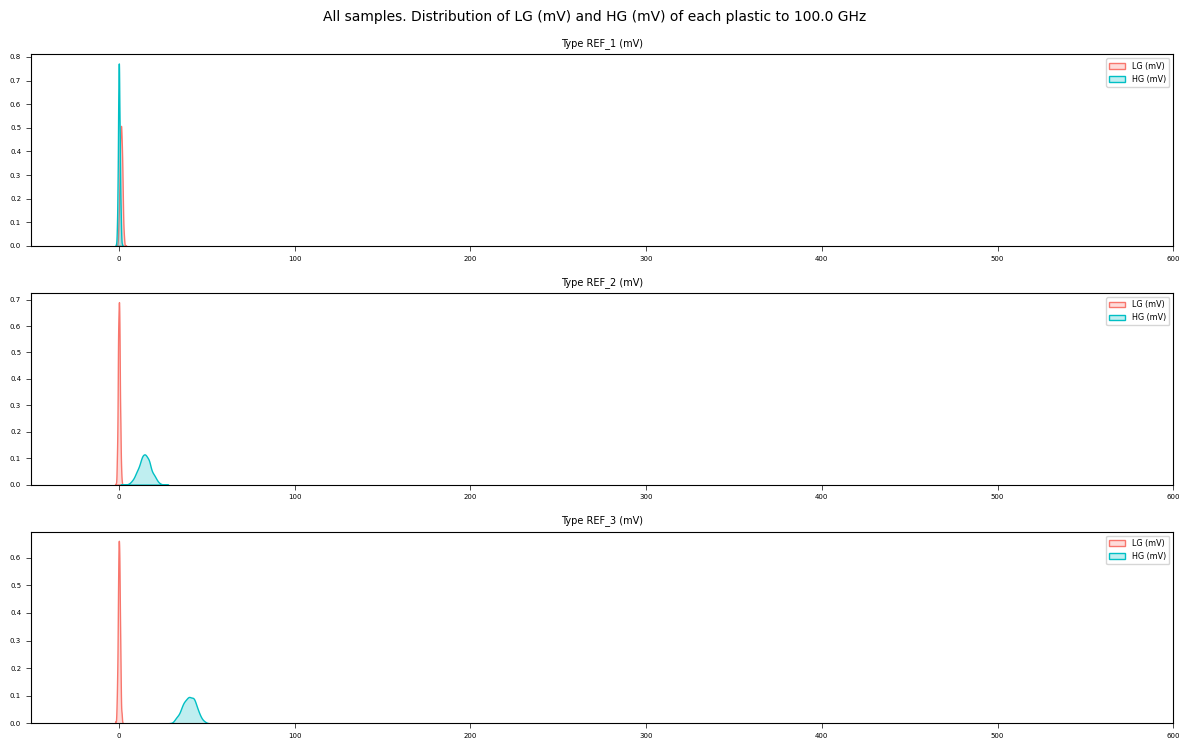

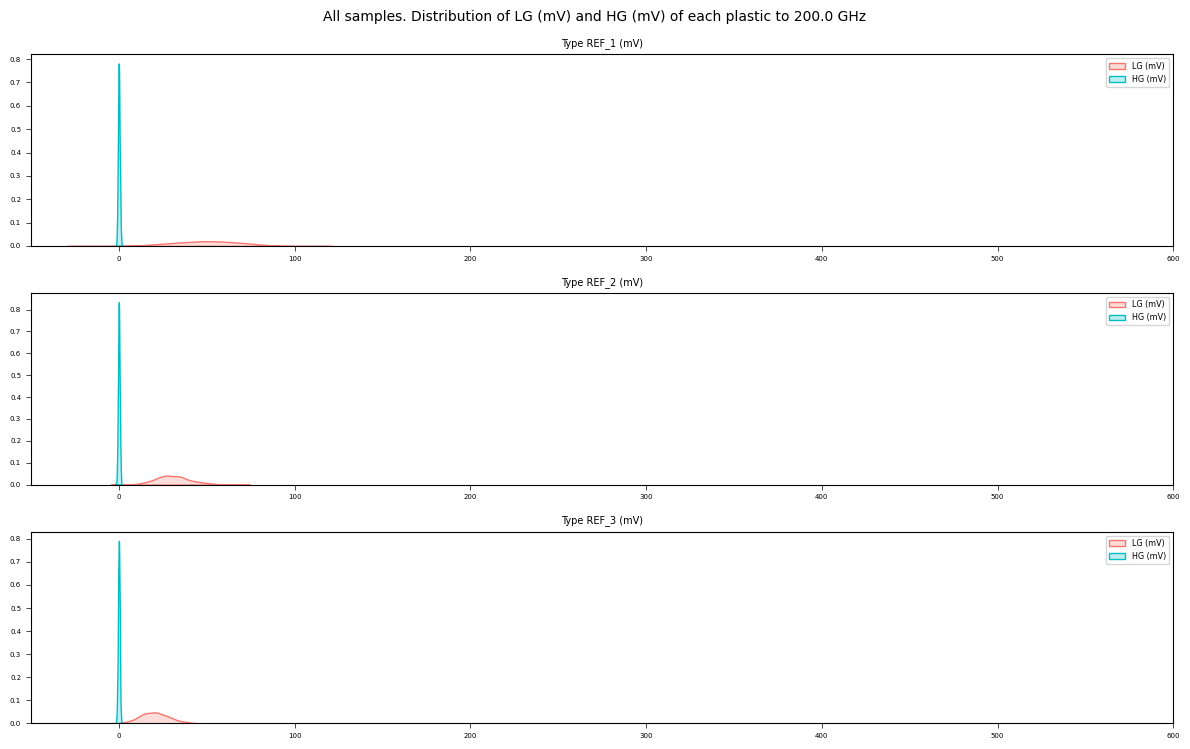

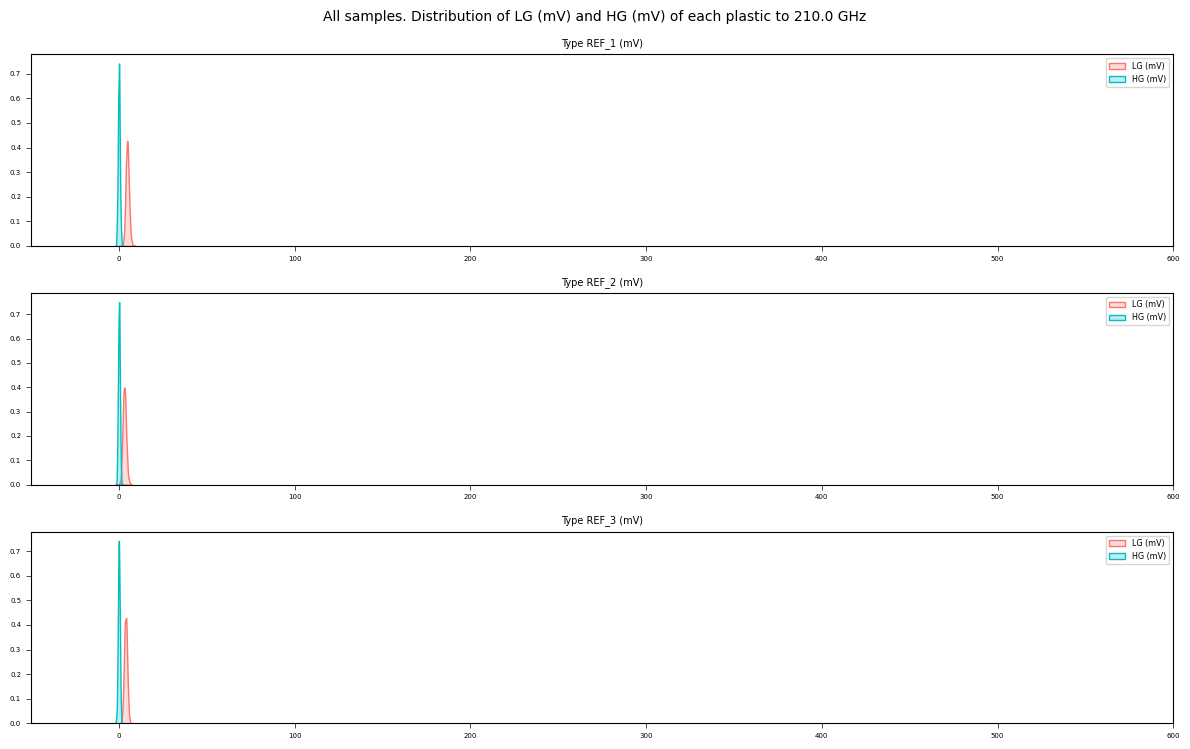

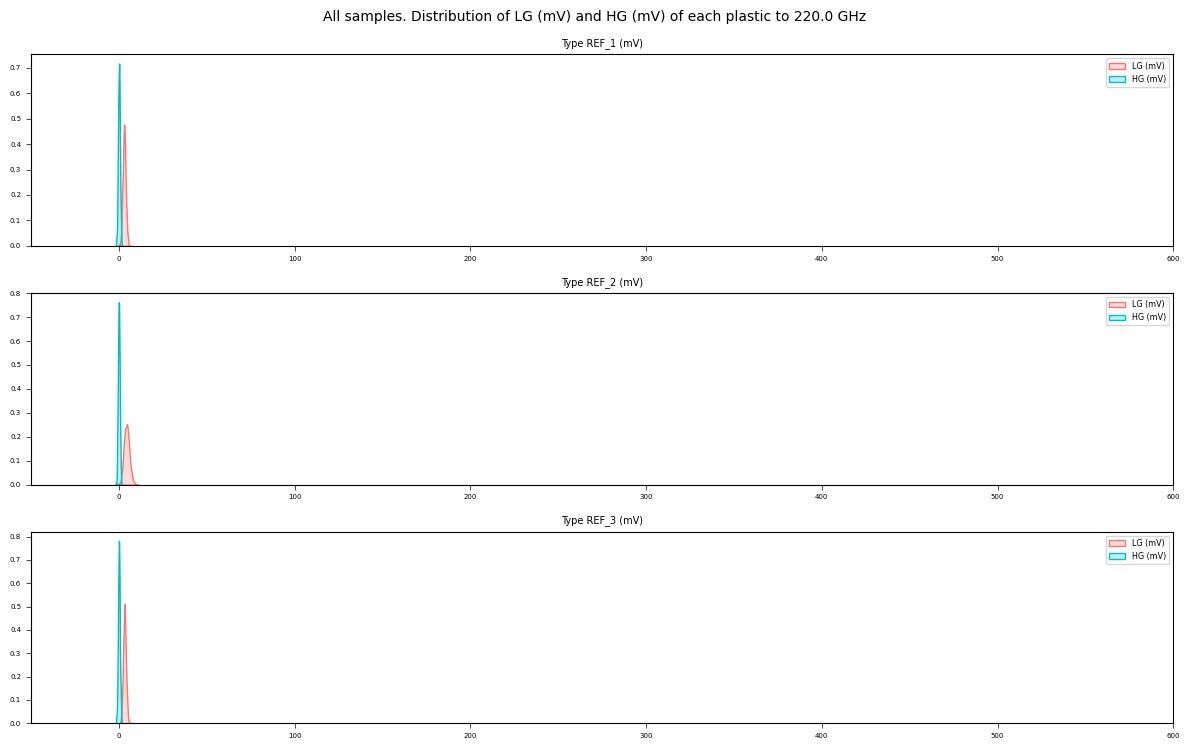

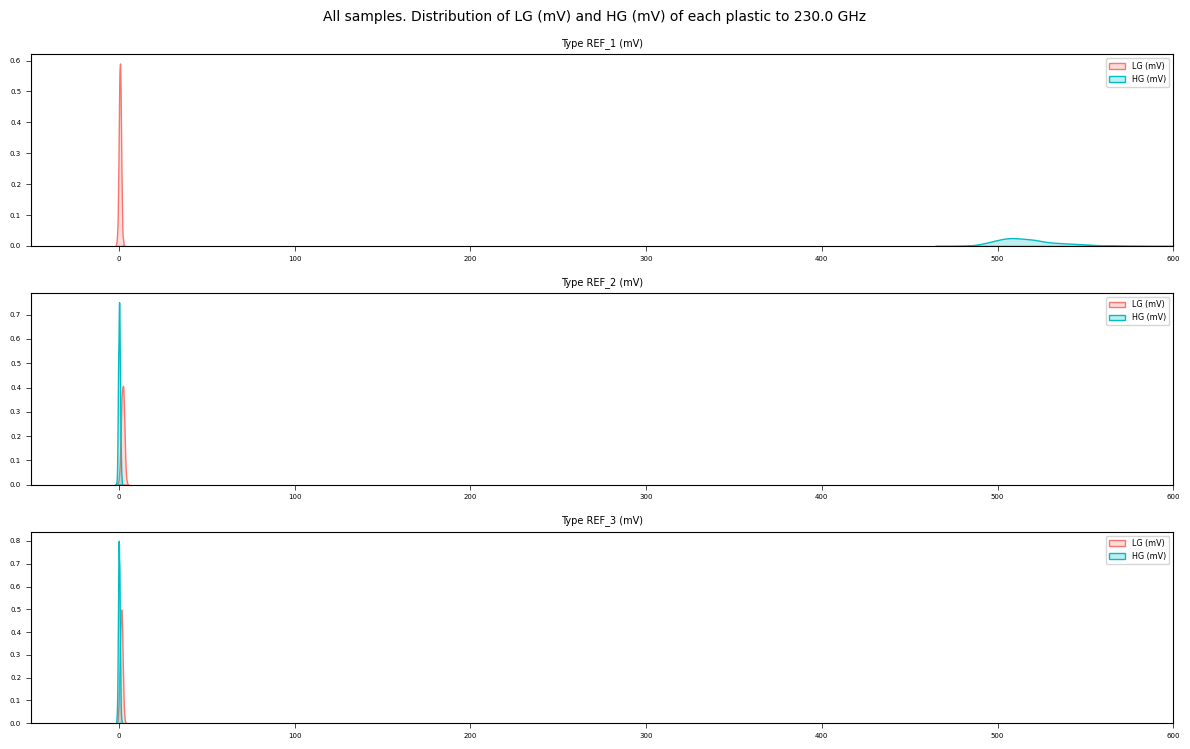

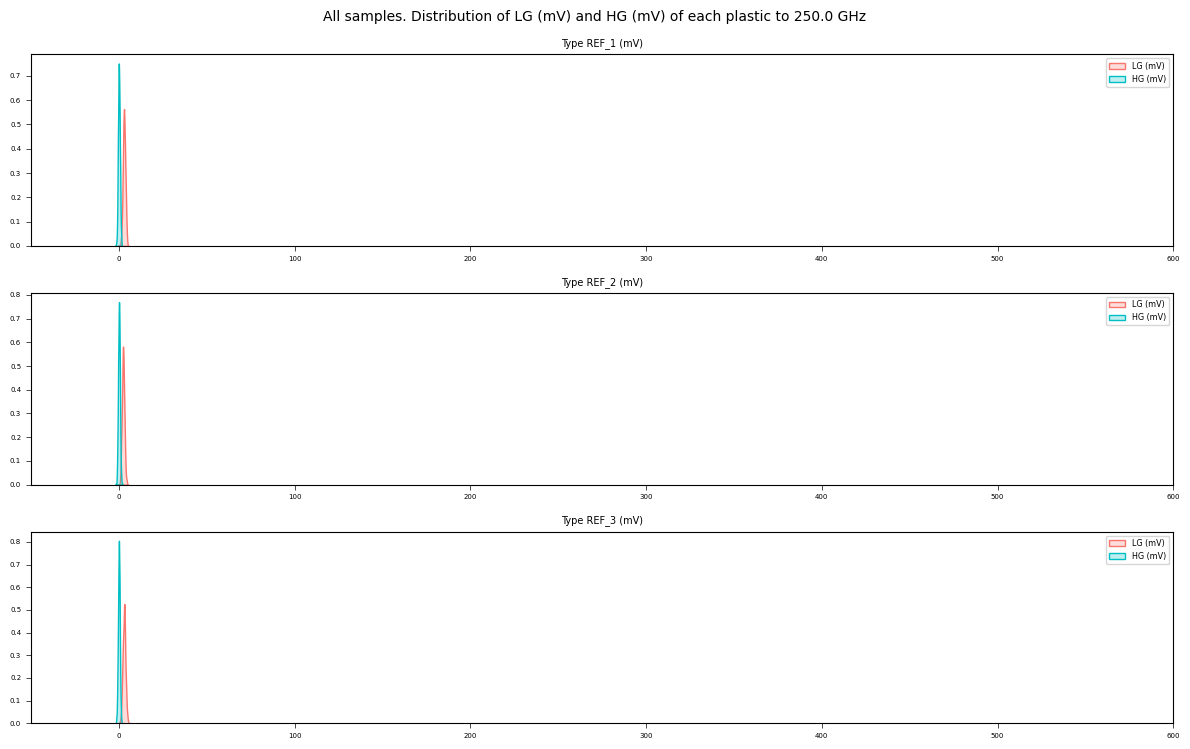

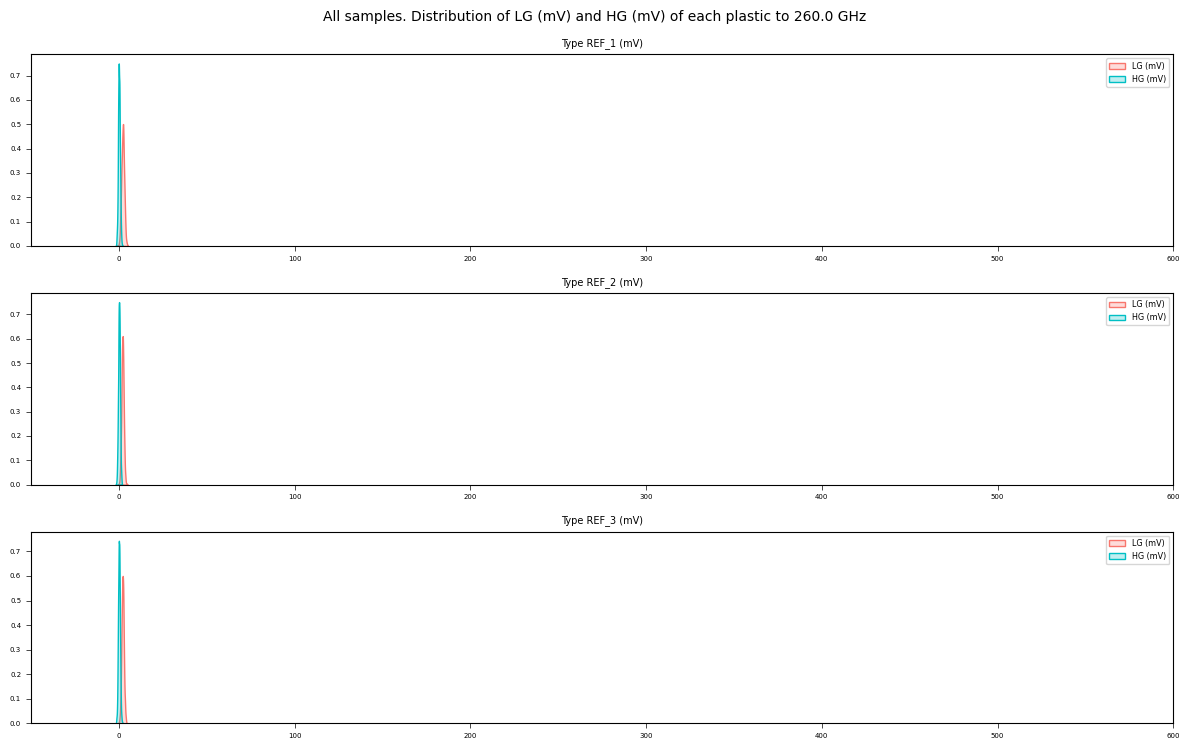

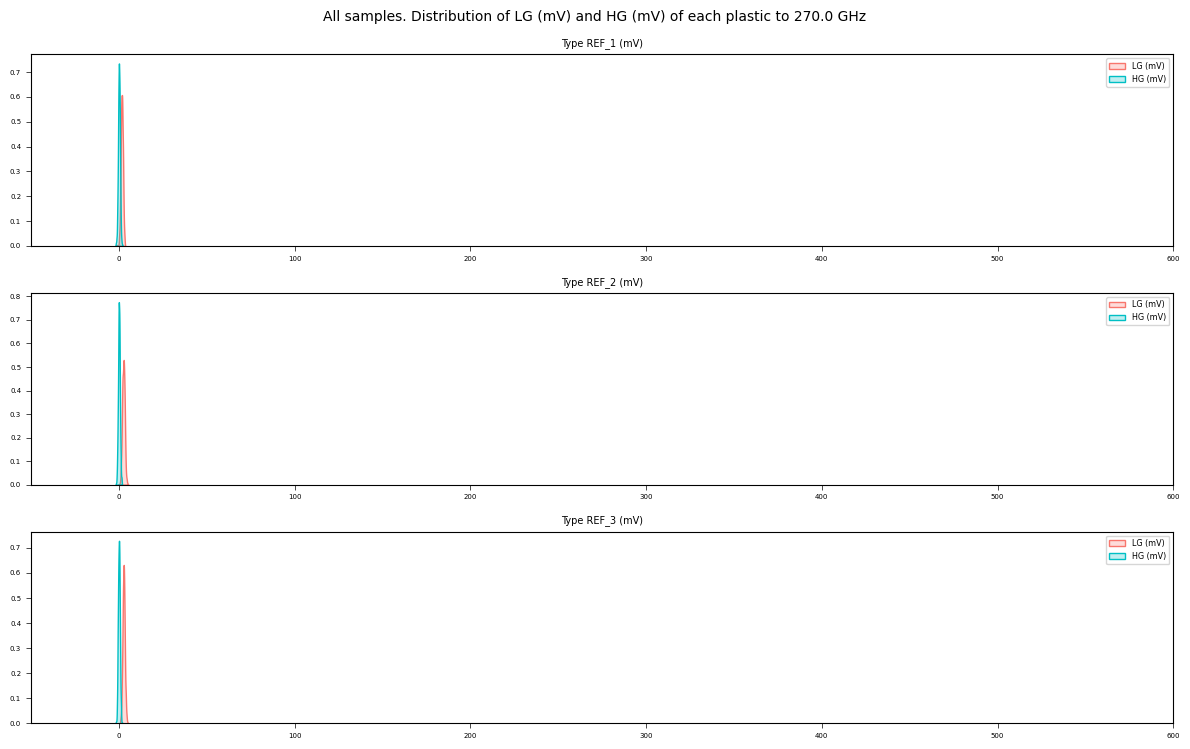

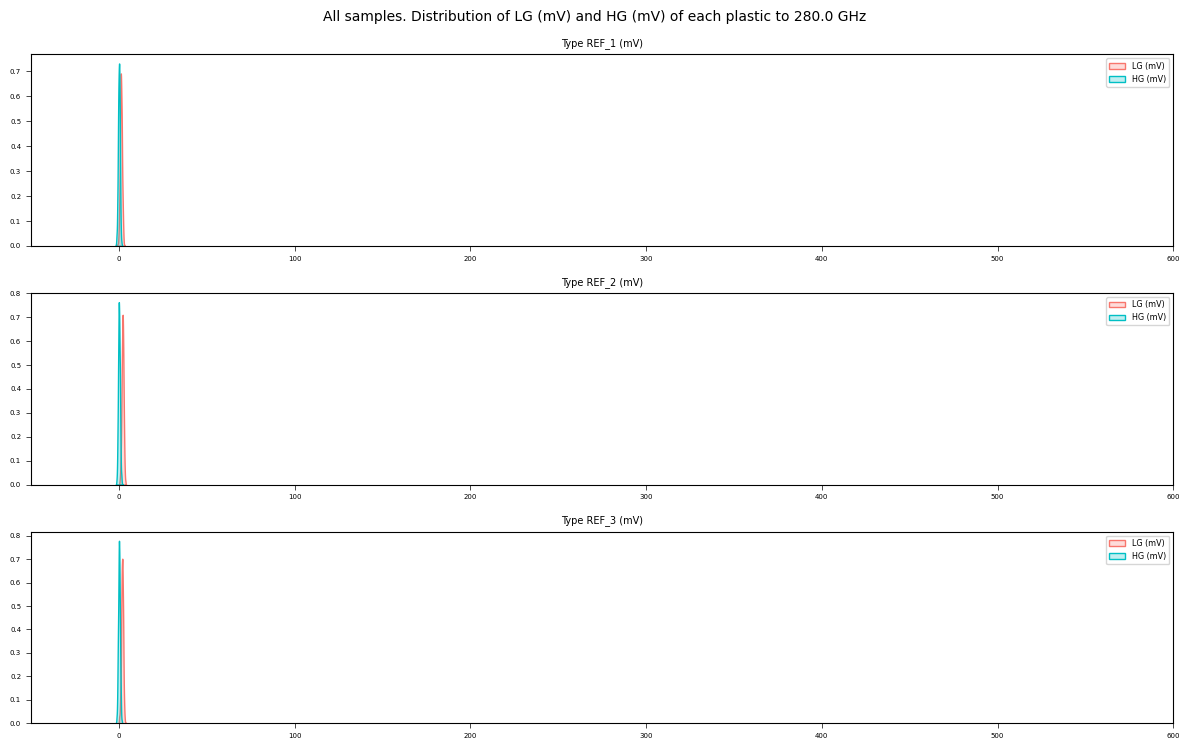

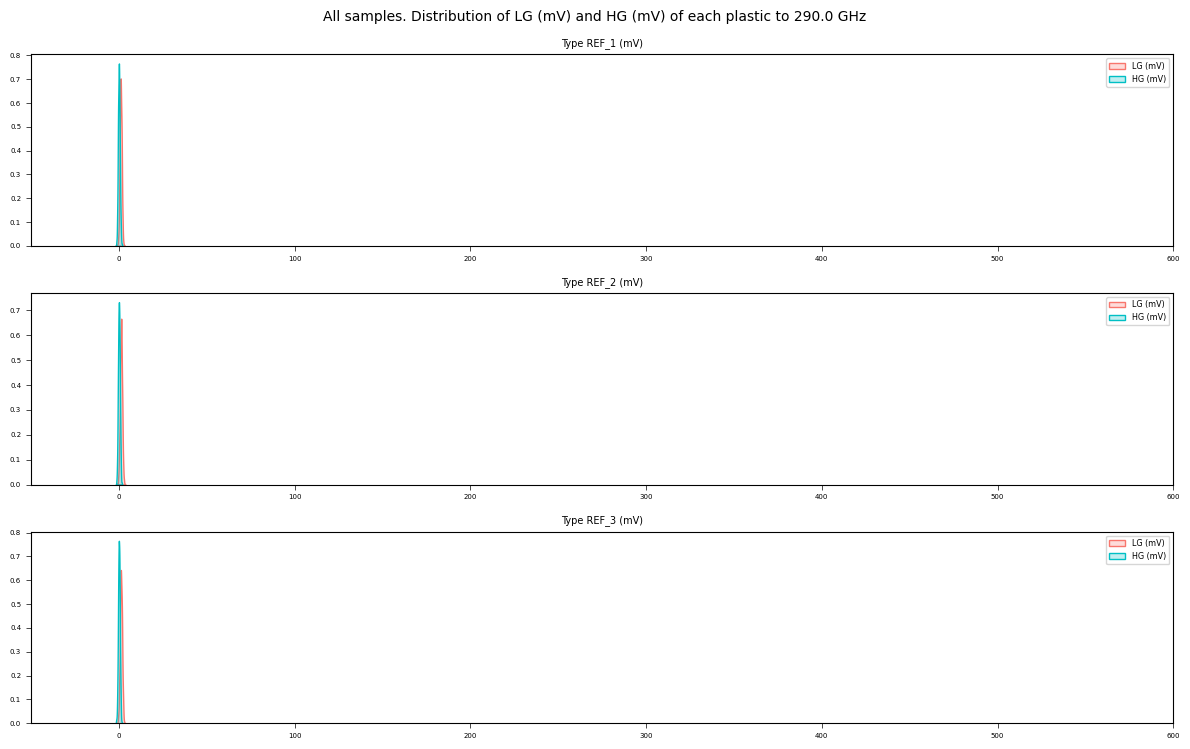

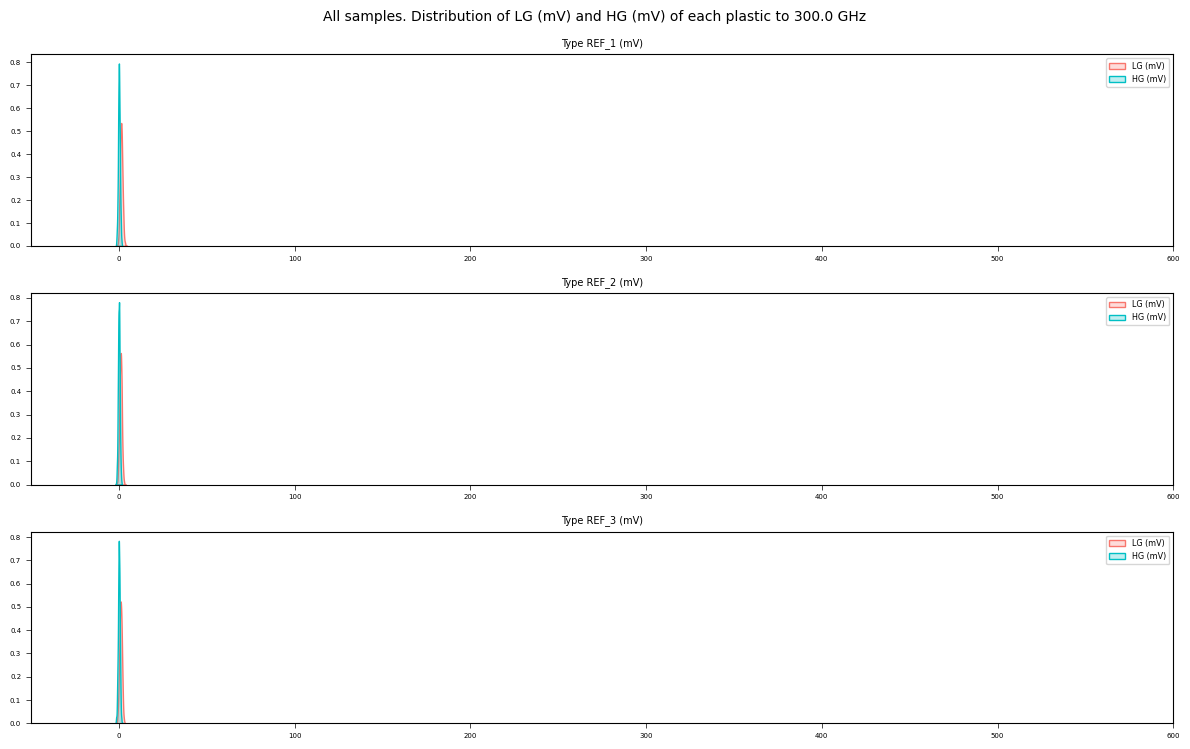

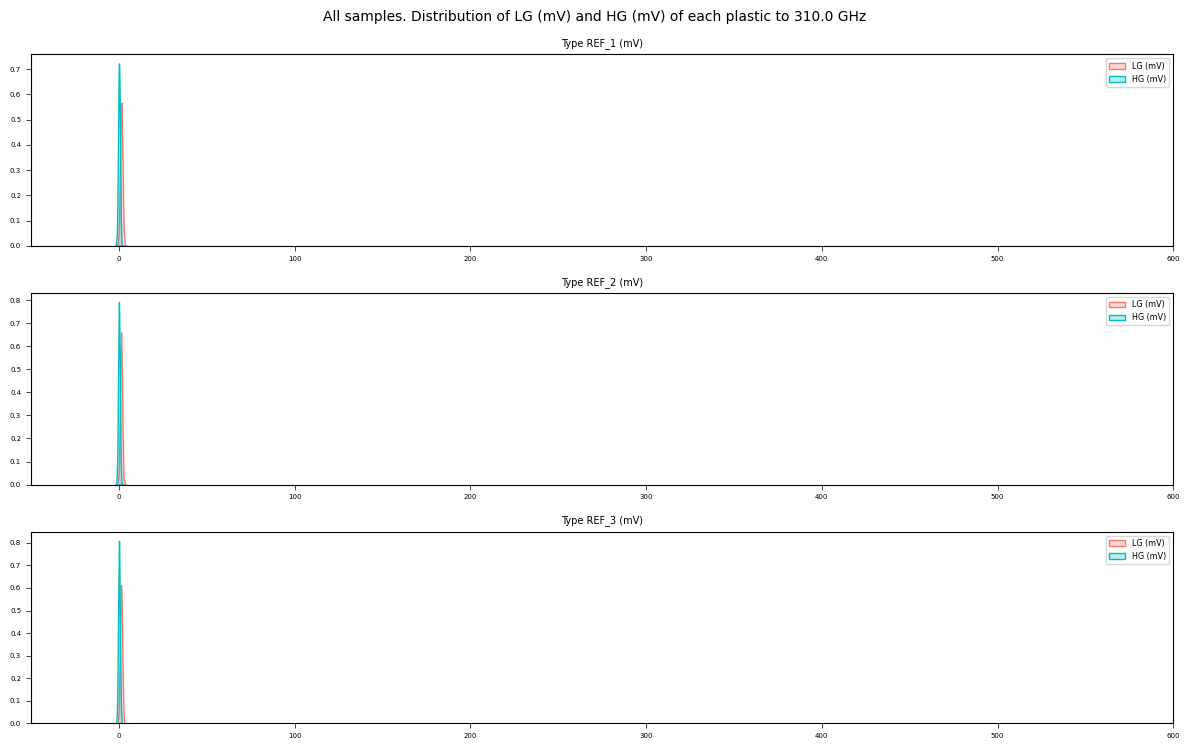

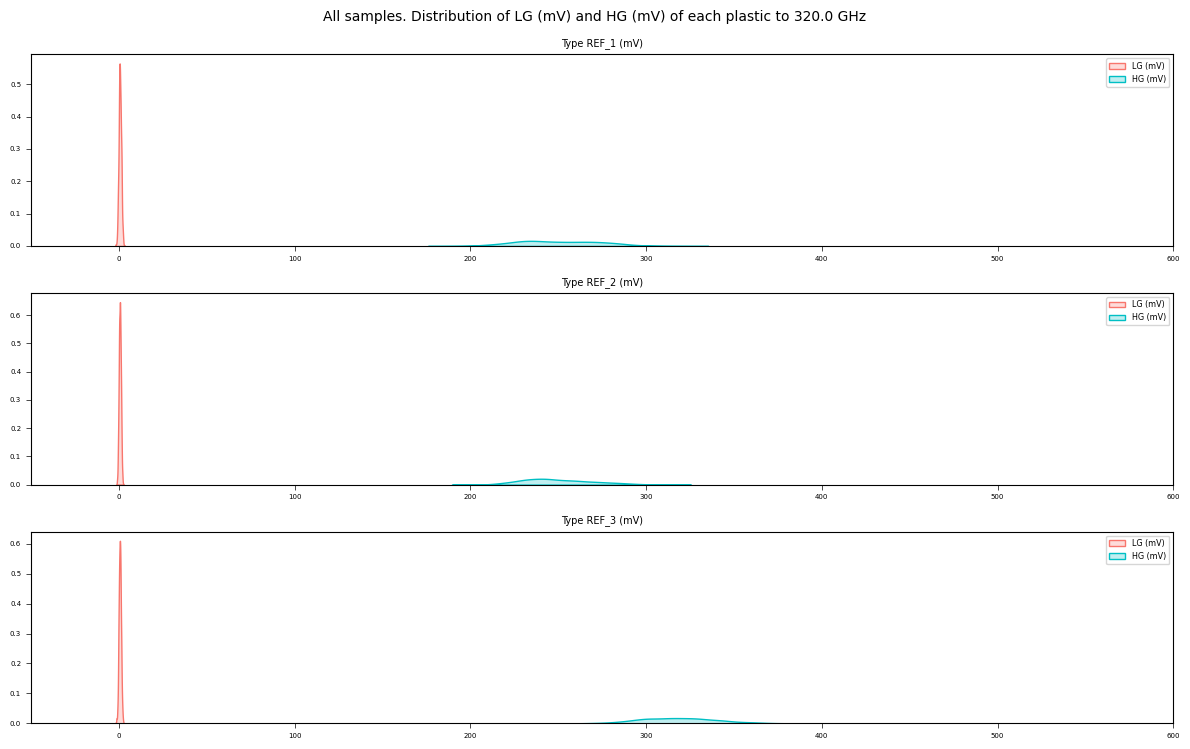

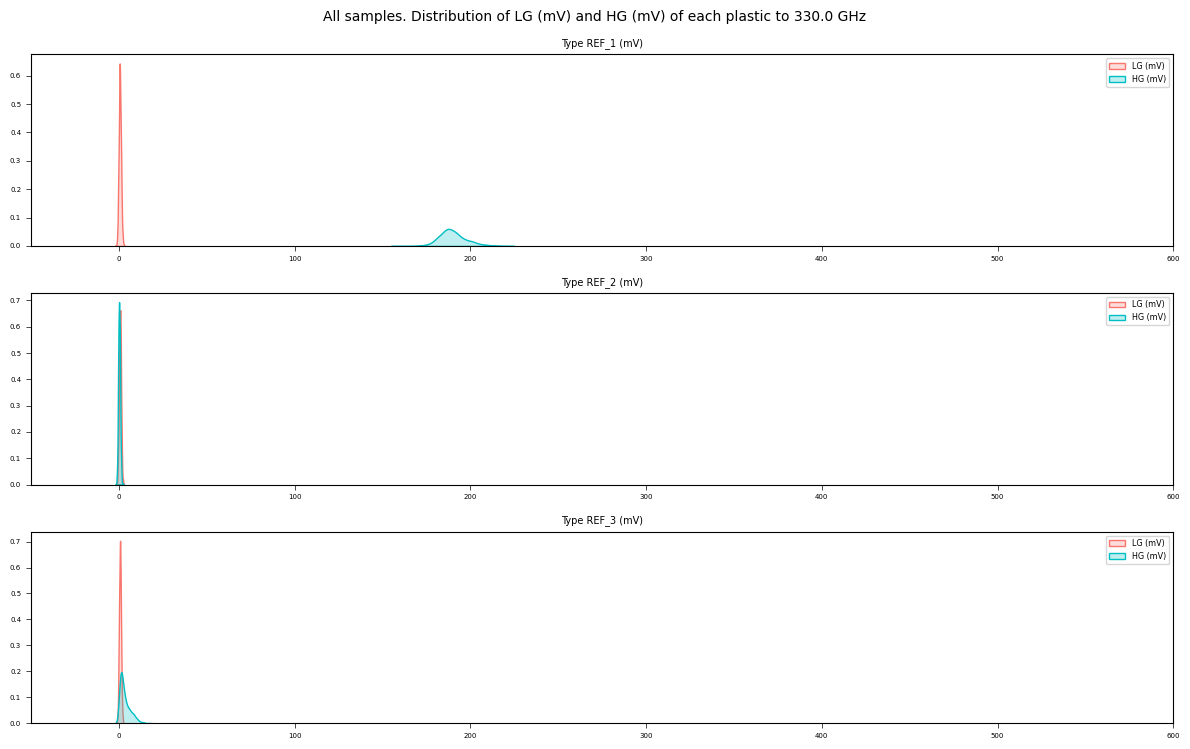

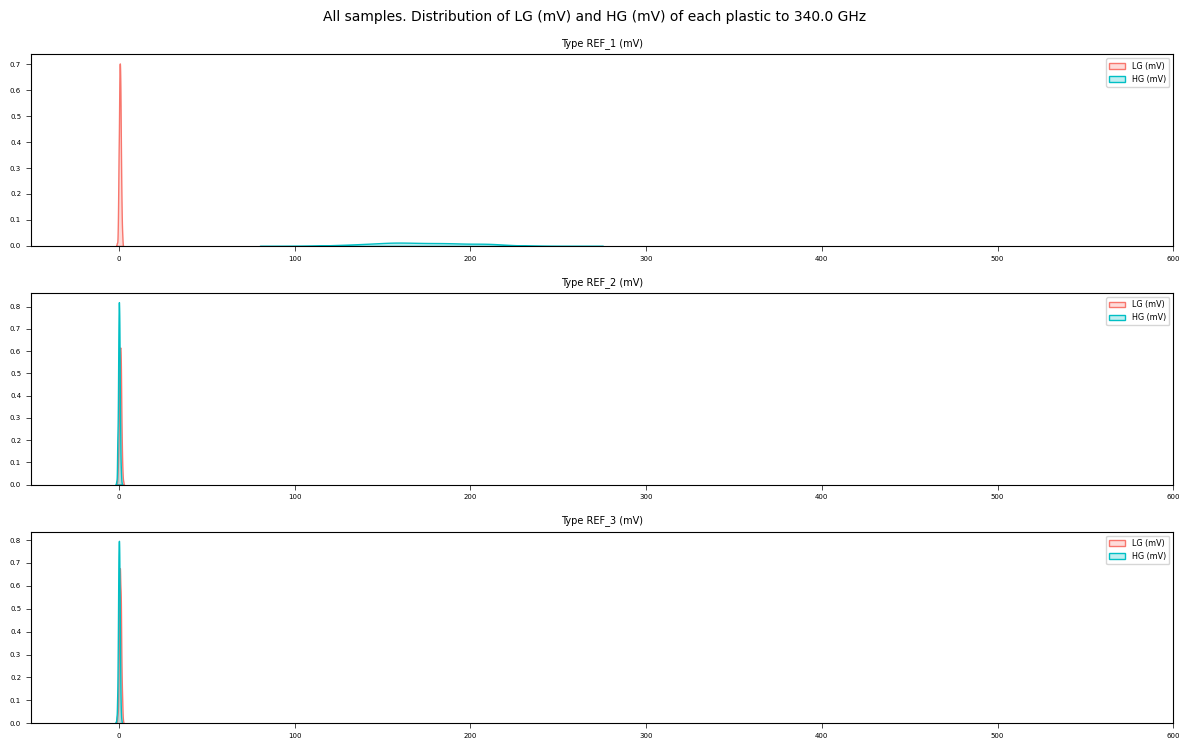

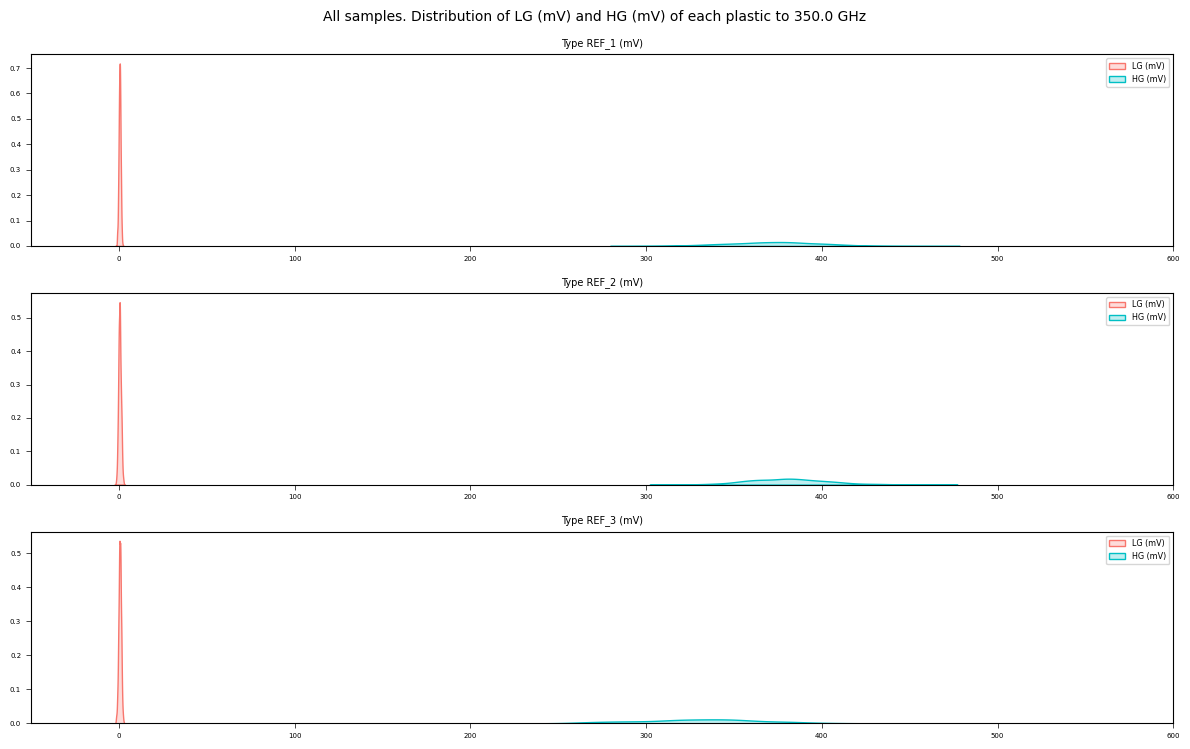

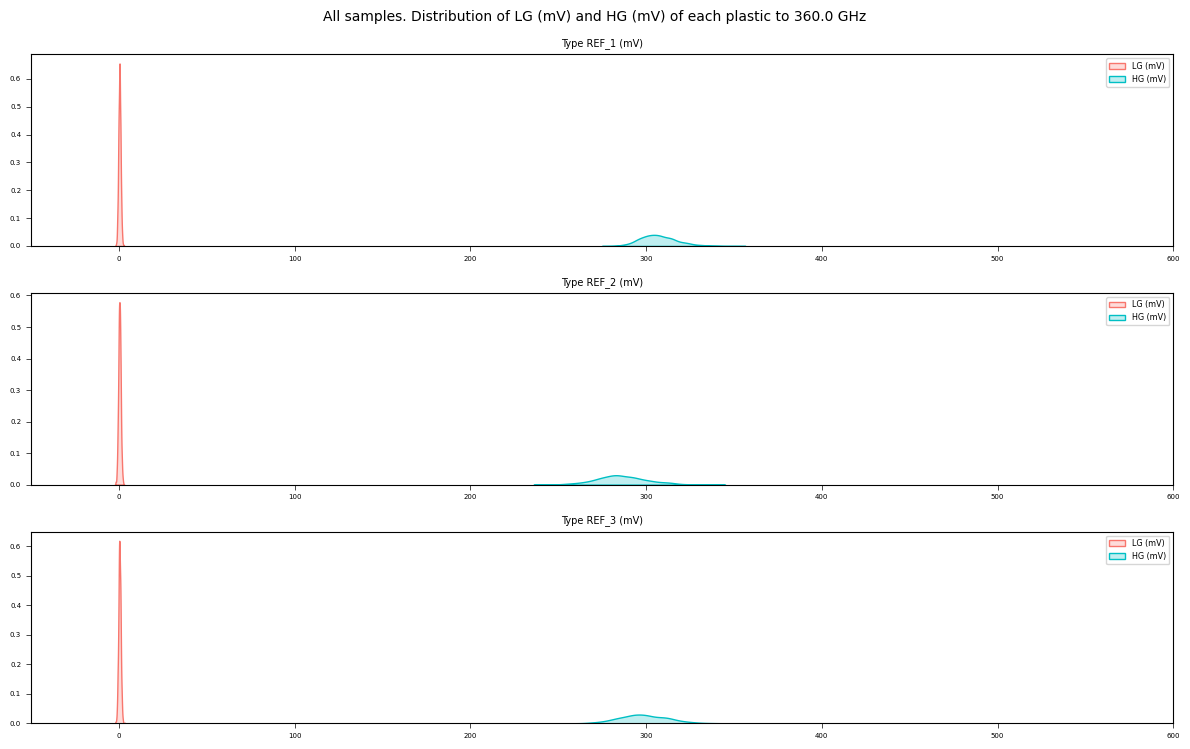

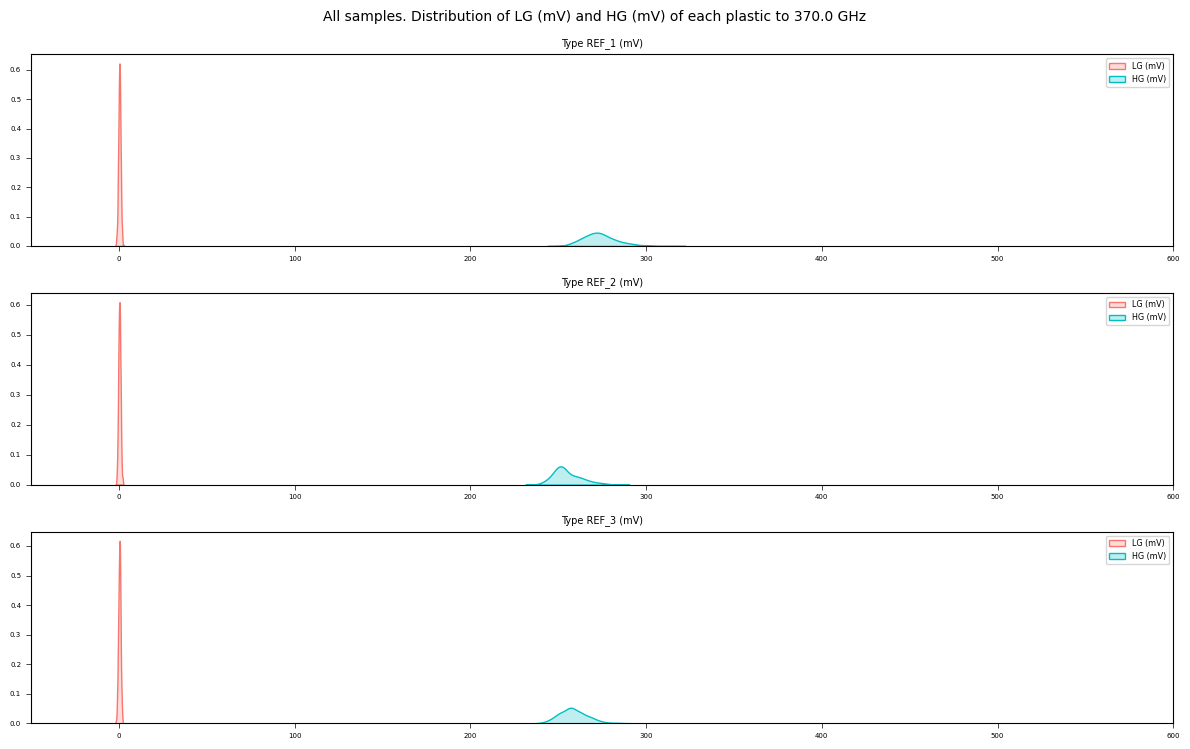

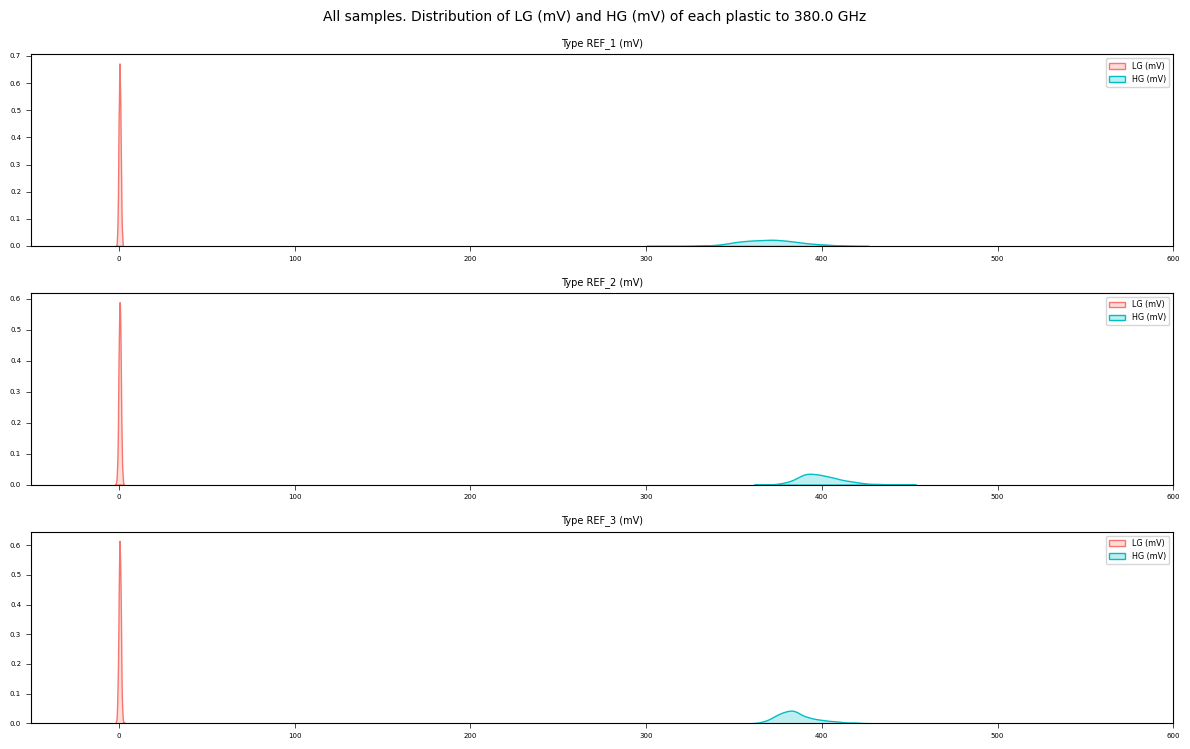

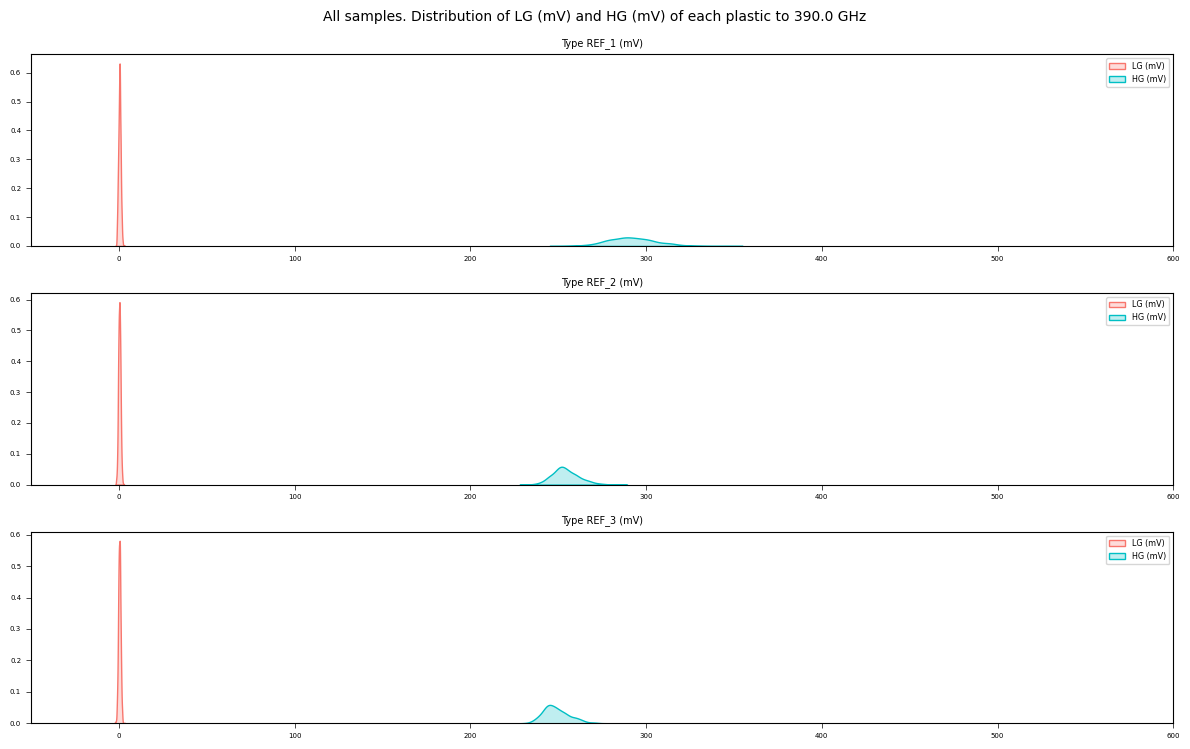

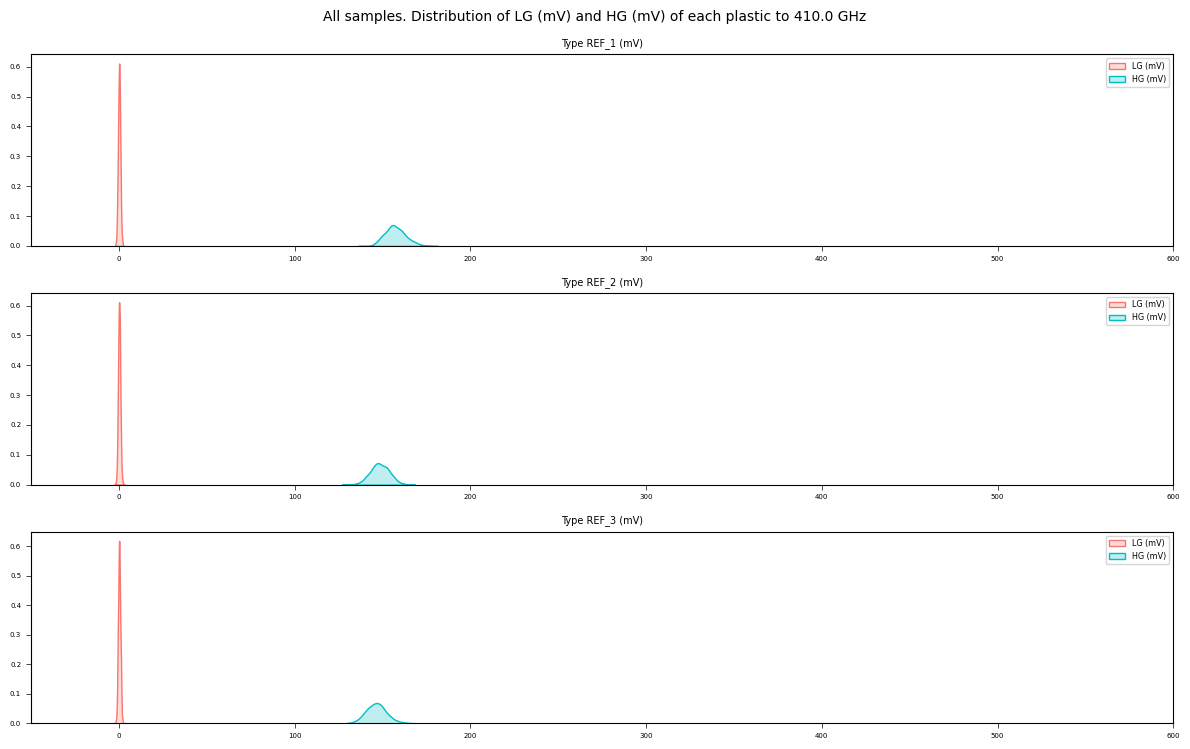

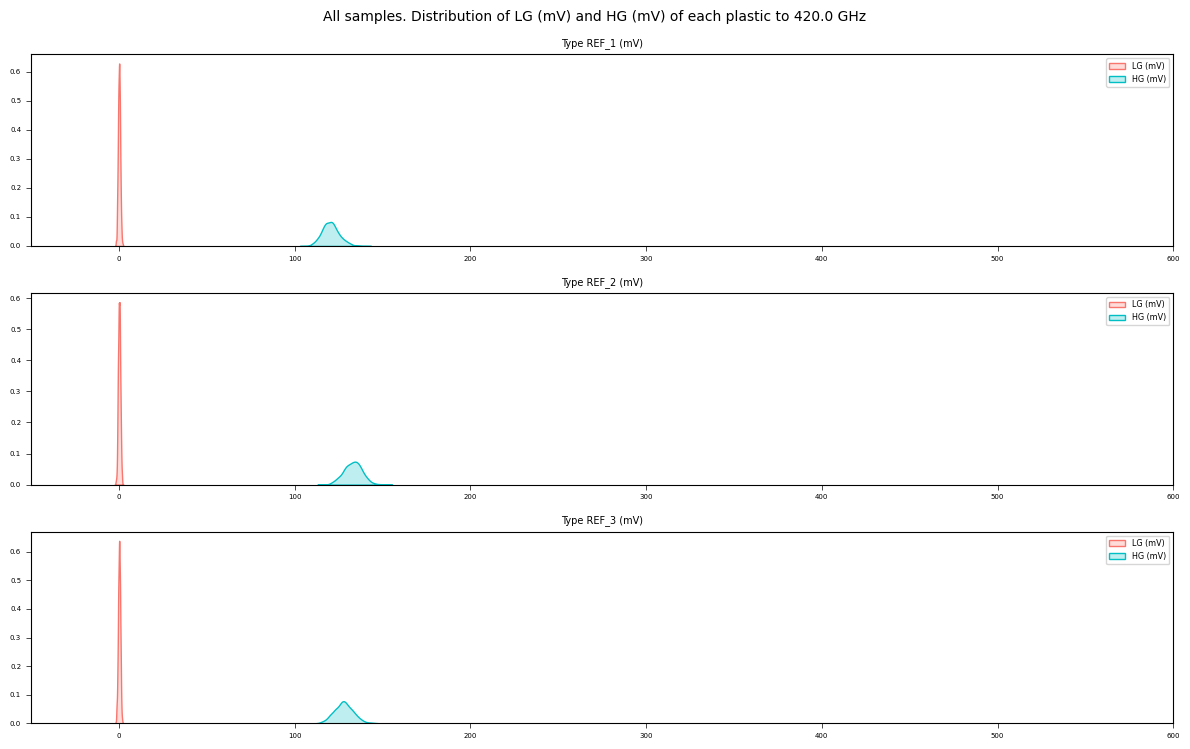

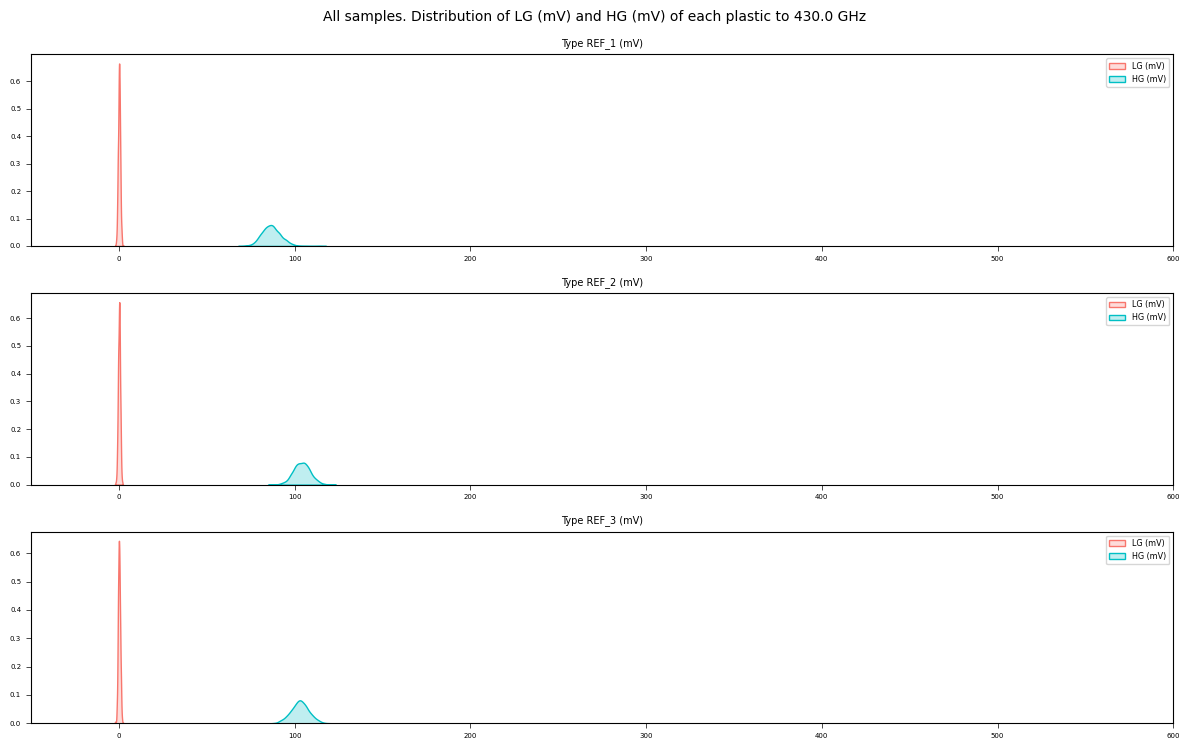

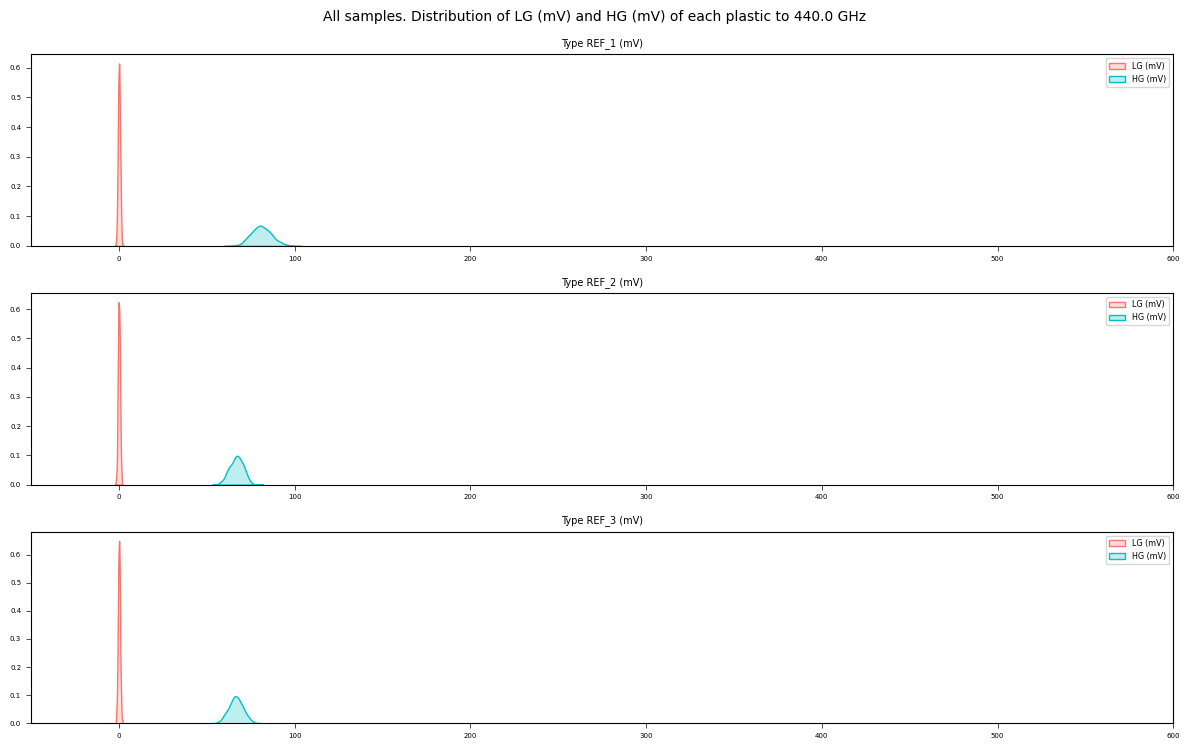

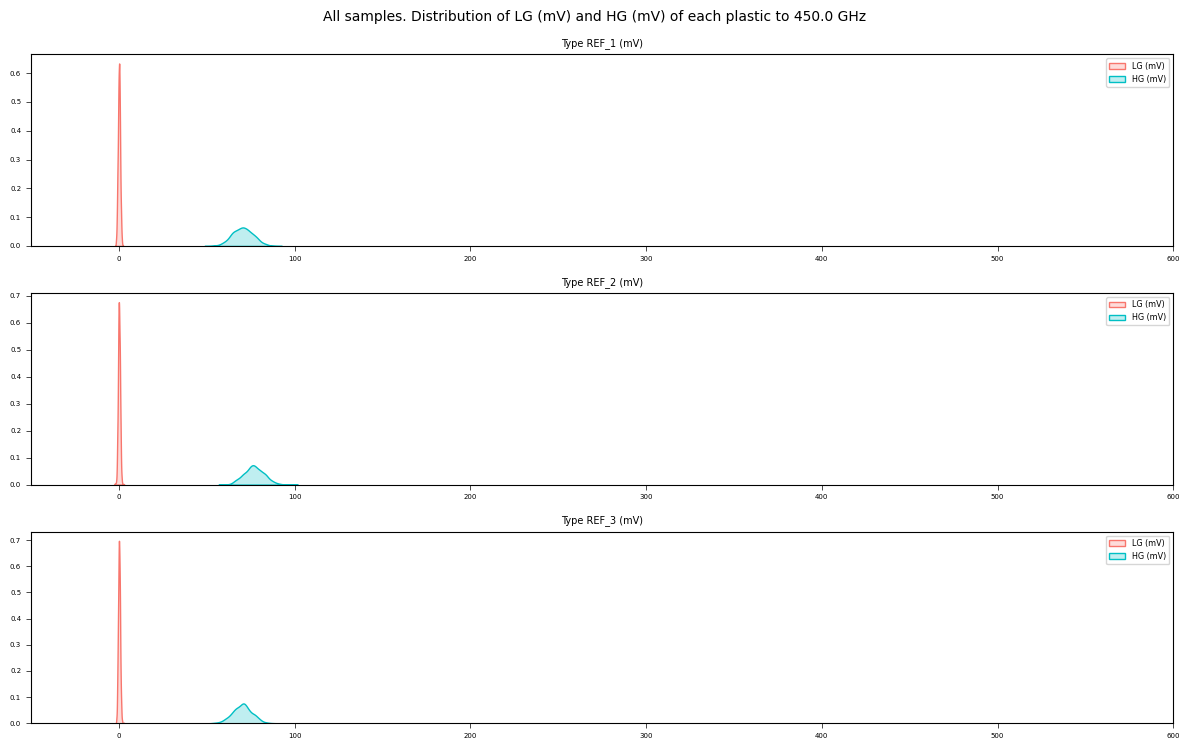

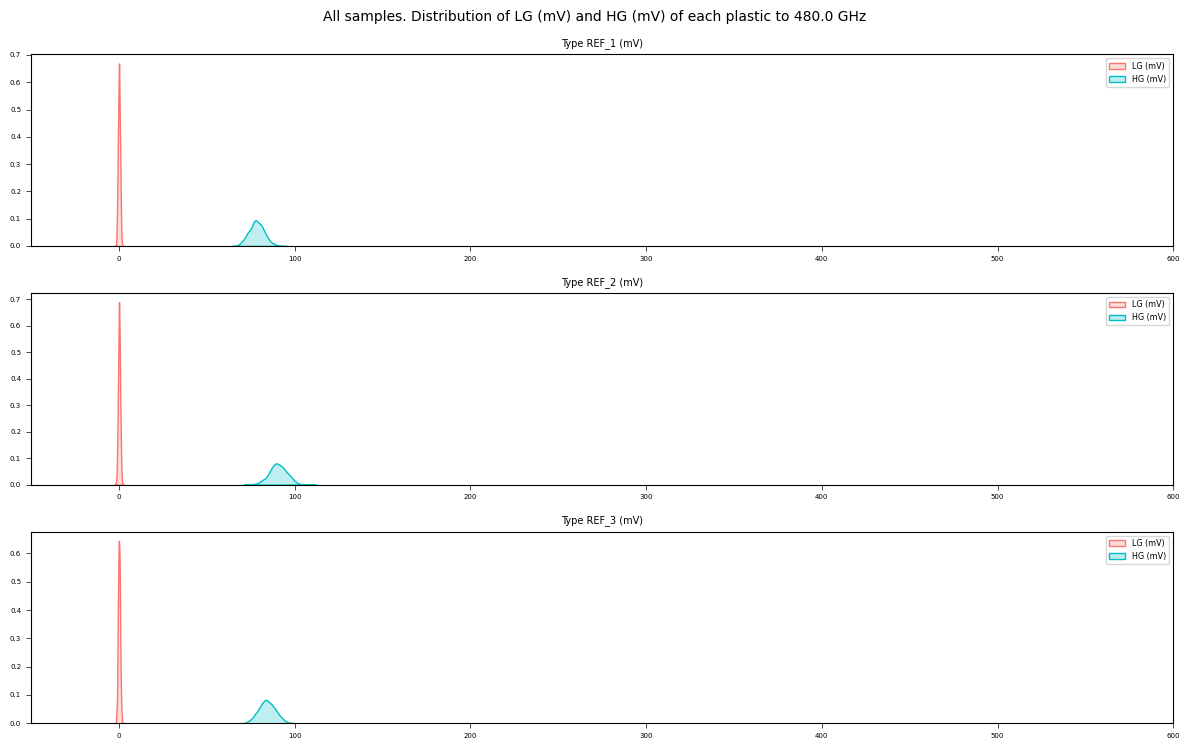

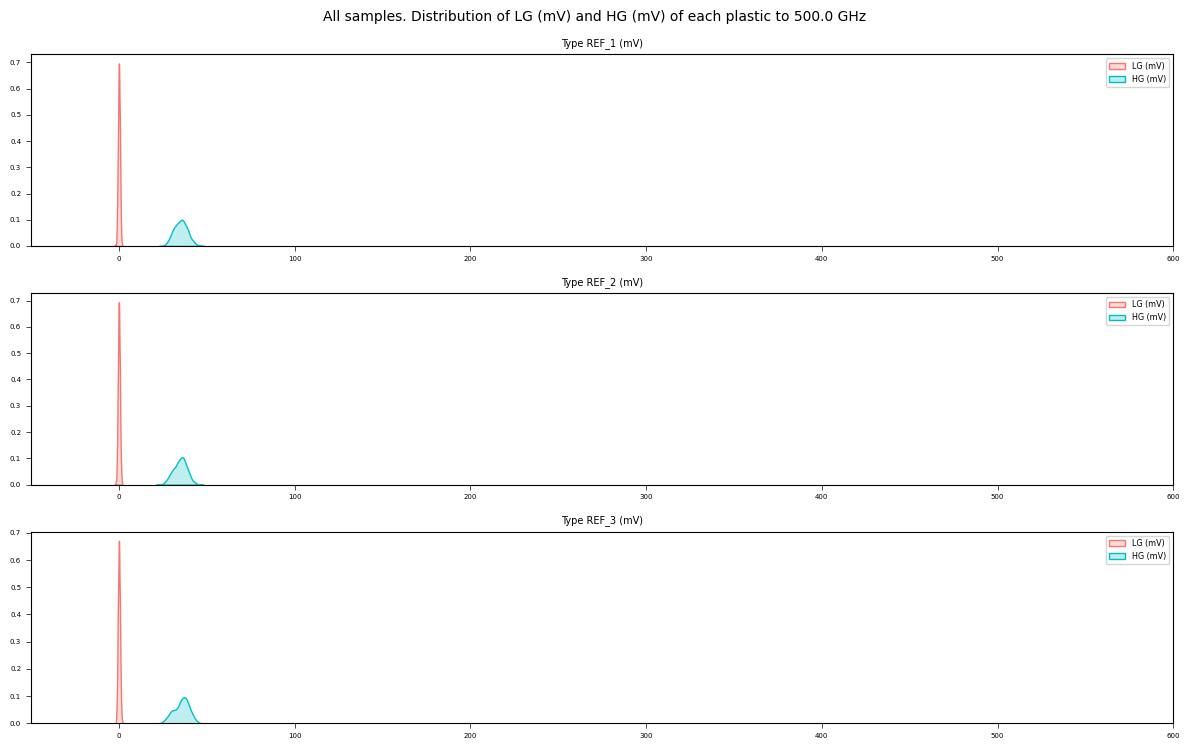

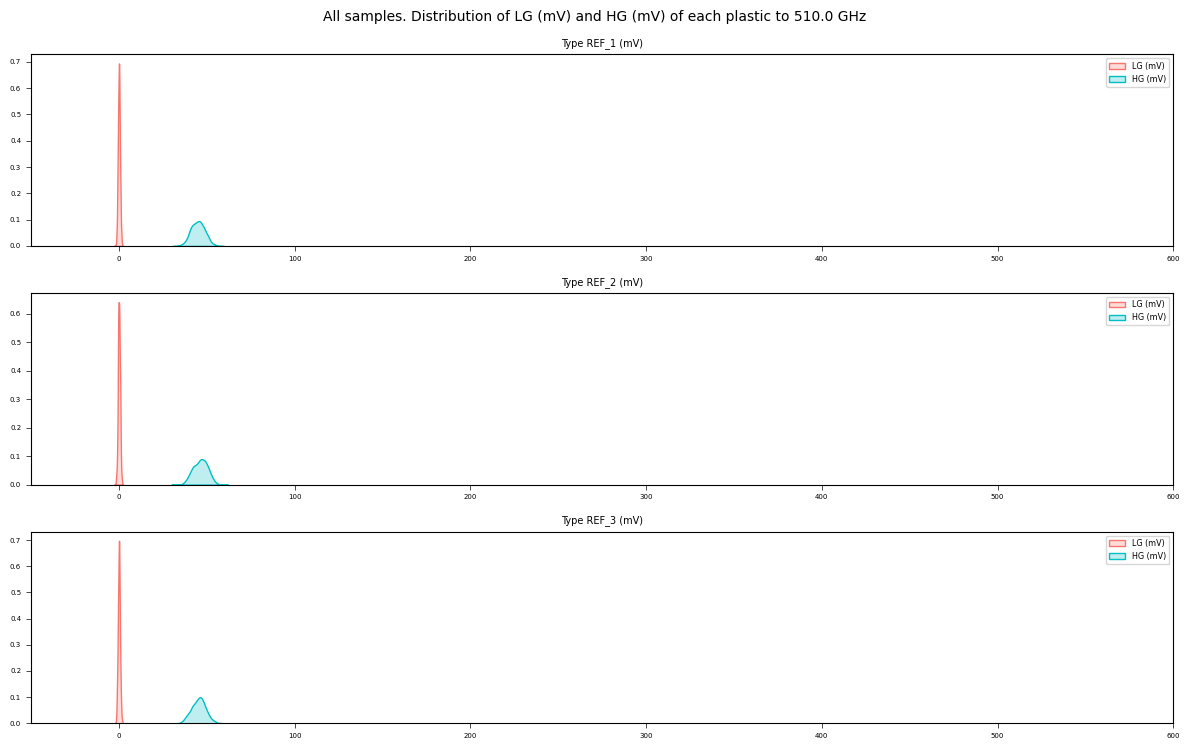

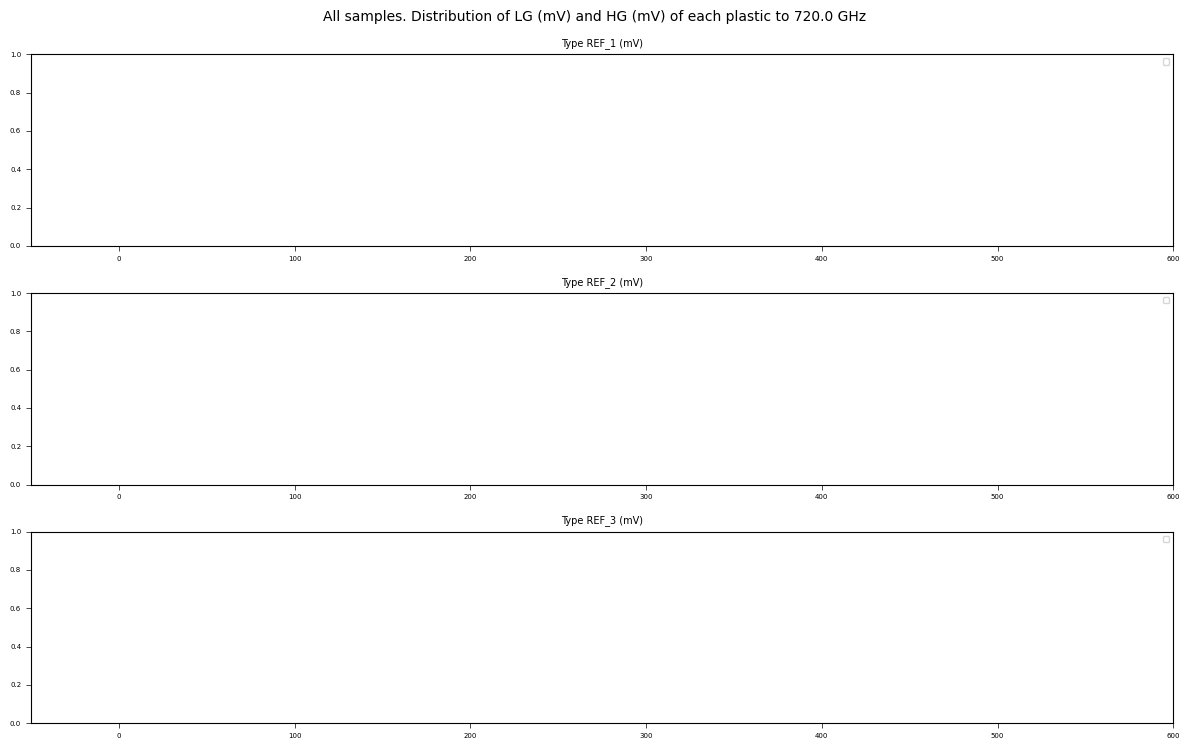

In [38]:
warnings.filterwarnings('ignore')

train_ex = df_balanced.copy()

print(train_ex.head())

for f in train_ex['Frequency (GHz)'].value_counts().index.sort_values().tolist():
    freq = f
    ncols = 1
    nrows = 3
    nums_plastics = 0
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))
    if ncols == 1:
        axes = axes.flatten()
    
    for r in range(nrows):
        t = train_ex['Sample'].value_counts().index.sort_values().tolist()
        if nums_plastics < len(t):
            df_tmp = train_ex[(train_ex['Frequency (GHz)'] == freq) & (train_ex['Sample'] == t[nums_plastics])]
            sns.kdeplot(x=df_tmp['LG (mV)'], ax=axes[r], color='#F8766D', label='LG (mV)', fill=True)
            sns.kdeplot(x=df_tmp['HG (mV)'], ax=axes[r], color='#00BFC4', label='HG (mV)', fill=True)
            axes[r].legend(fontsize="xx-small")
            axes[r].set_ylabel('')
            axes[r].set_xlabel('')
            axes[r].set_title(f"Type {t[nums_plastics]} (mV)", fontsize=7)
            axes[r].tick_params(labelsize=5, width=0.5)
            axes[r].xaxis.offsetText.set_fontsize(6)
            axes[r].yaxis.offsetText.set_fontsize(4)
            axes[r].set_xlim(-50, 600)
            nums_plastics += 1
        else:
            axes[r].axis('off')
    plt.suptitle(f"All samples. Distribution of LG (mV) and HG (mV) of each plastic to {freq} GHz", y=0.93, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




## Data Windowing



In [ ]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s

data_percentage = 0
data_percentage_test = 0

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file

output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)


## Clustering

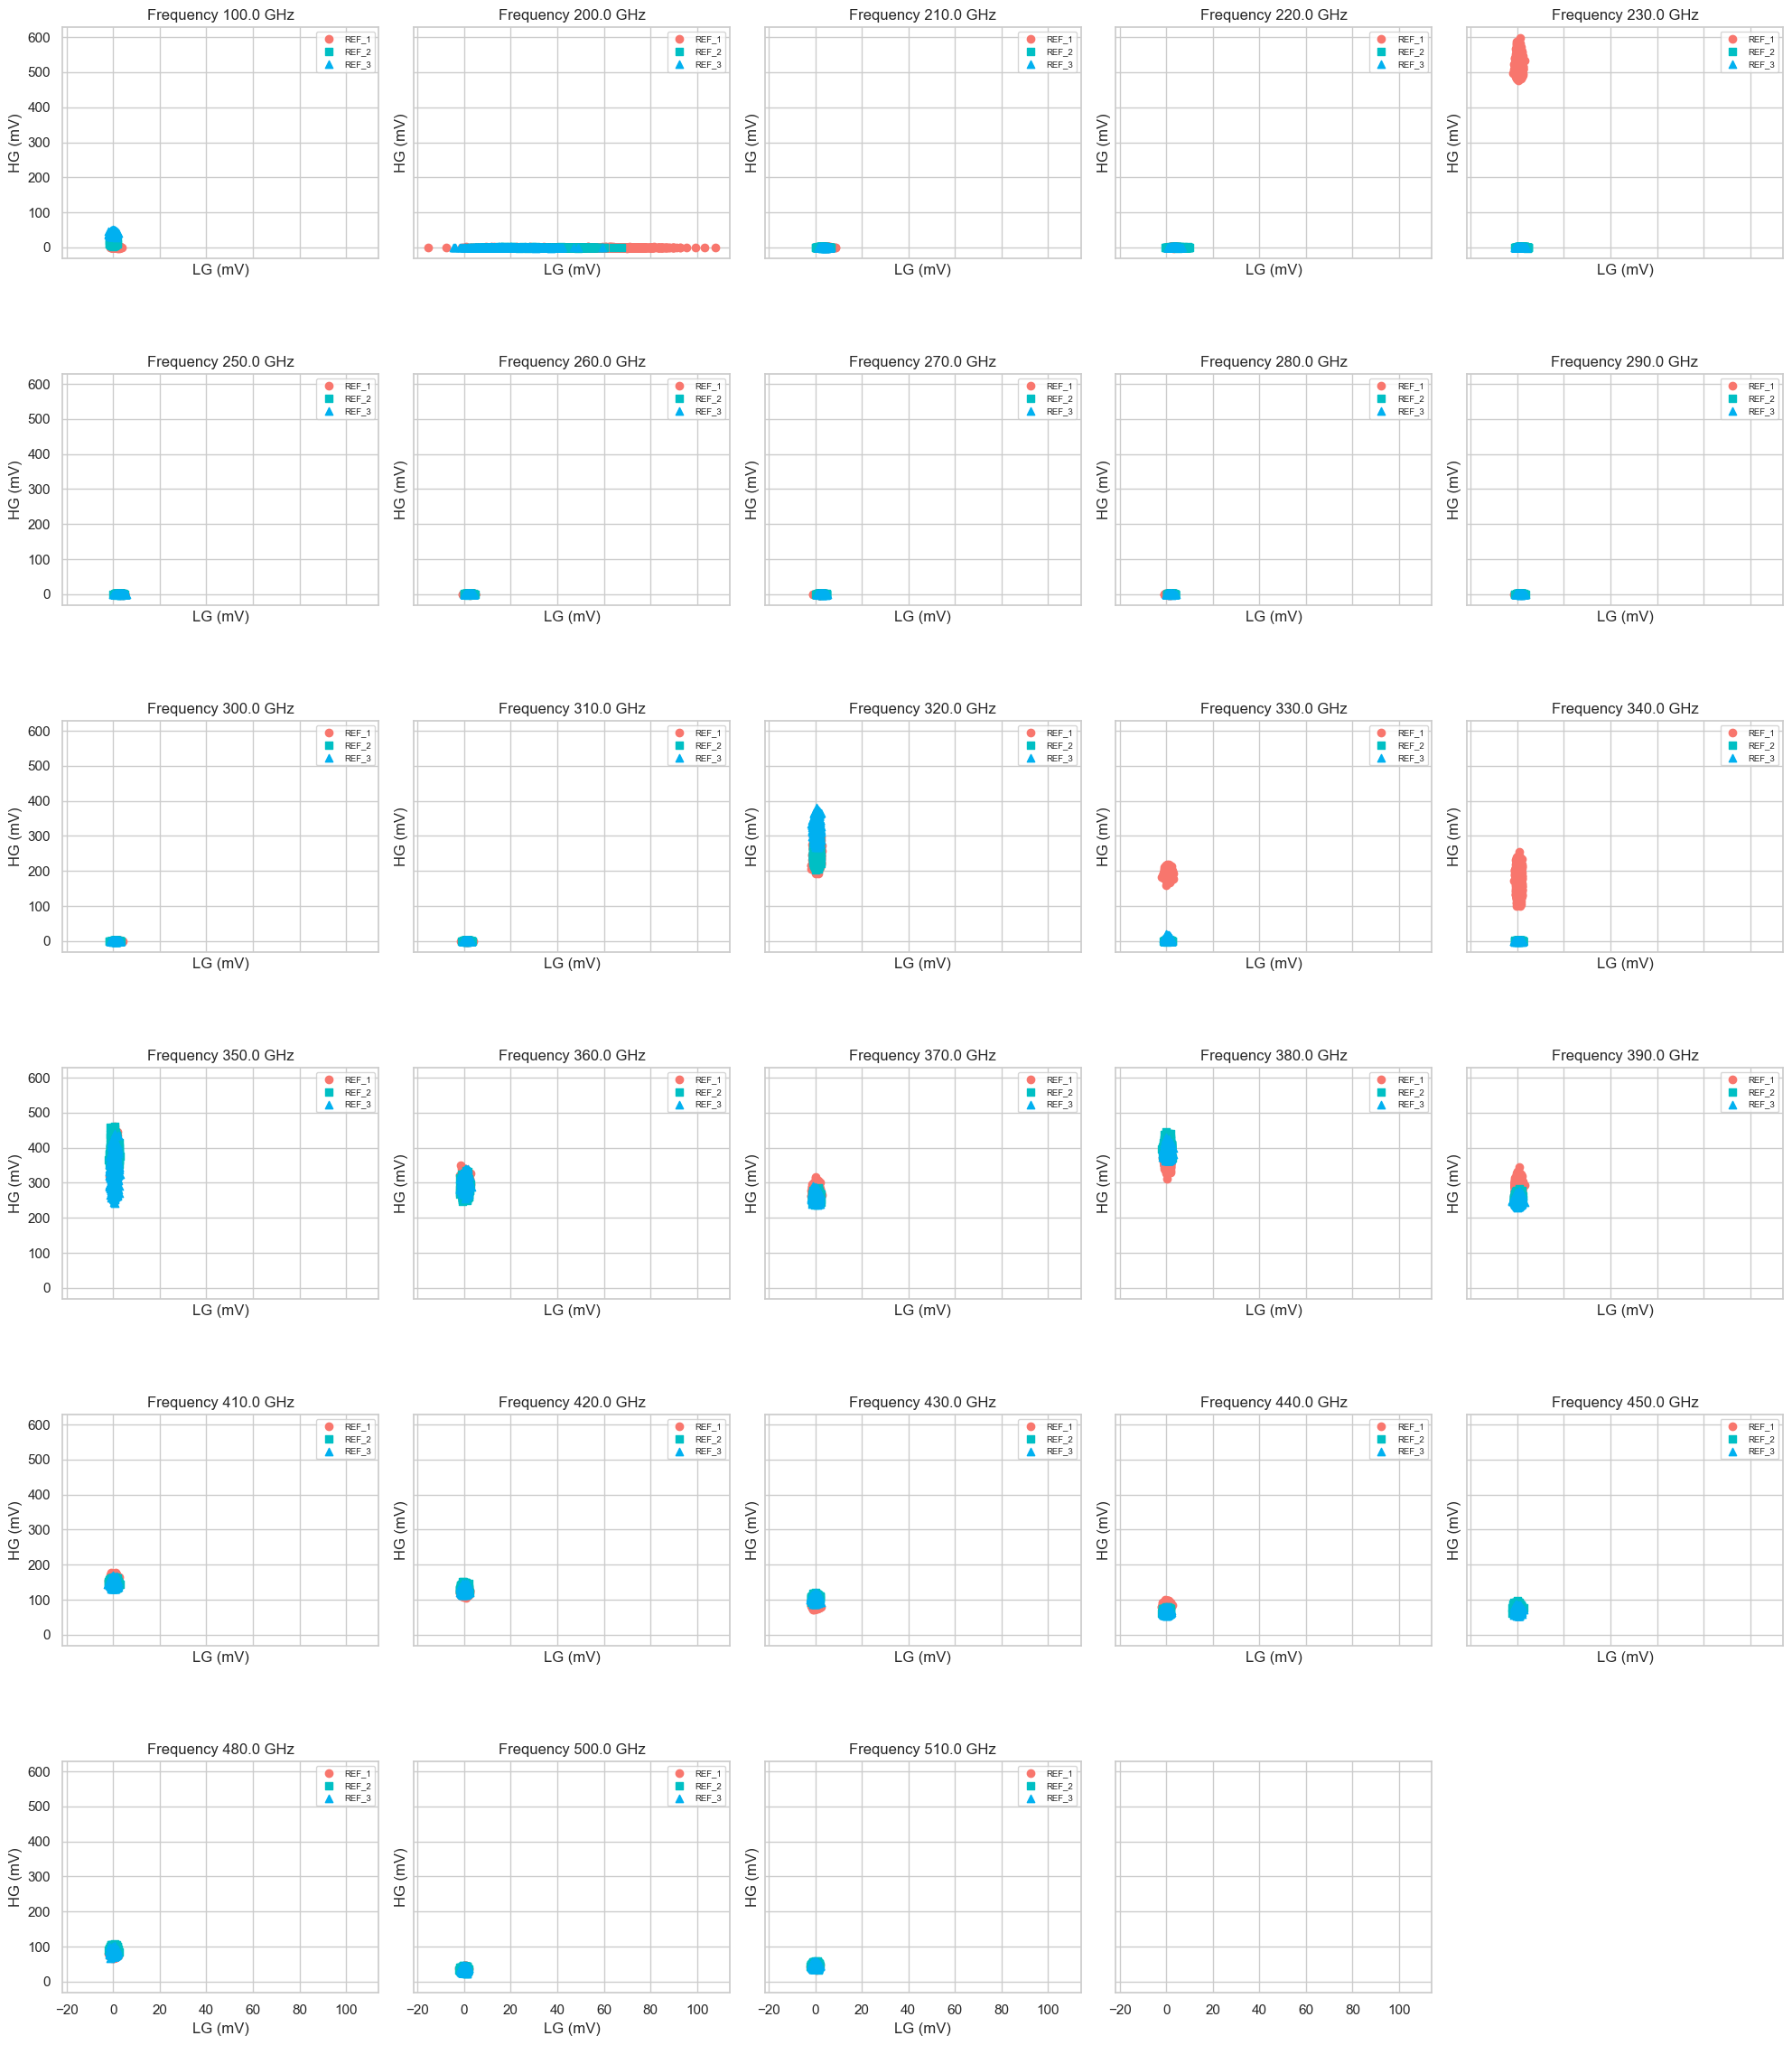

In [62]:
# Unsupervised clusterization of every sample for each frequency (do not use labels for the clustering, just for the visualization afterwards)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the number of clusters
n_clusters = 3

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
])

# Define the frequencies and samples
frequencies = train_ex['Frequency (GHz)'].unique()
samples = train_ex['Sample'].unique()

# Define the colors and markers
colors = ['#F8766D', '#00BFC4', '#00B0F0']
markers = ['o', 's', '^']

# Create subplots
ncols = 5
nrows = int(np.ceil(len(frequencies) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4), sharex=True, sharey=True)

# Ensure axes is iterable
axes = axes.flatten()

# Loop over frequencies
for idx, f in enumerate(frequencies):
    n_samples = 0
    # Loop over samples
    for s in samples:
        # Filter the DataFrame
        df_tmp = train_ex[(train_ex['Frequency (GHz)'] == f) & (train_ex['Sample'] == s)]
        # Check if there are enough samples
        if len(df_tmp) >= n_clusters:
            # Fit the pipeline
            pipe.fit(df_tmp[['LG (mV)', 'HG (mV)']])
            # Get the cluster labels
            labels = pipe.named_steps['kmeans'].labels_
            # Plot the data
            axes[idx].scatter(df_tmp['LG (mV)'], df_tmp['HG (mV)'],
                              color=colors[n_samples % len(colors)],
                              marker=markers[n_samples % len(markers)],
                              label=s)
            axes[idx].set_title(f"Frequency {f} GHz")
            axes[idx].set_xlabel('LG (mV)')
            axes[idx].set_ylabel('HG (mV)')
            axes[idx].legend(fontsize='xx-small')
            n_samples += 1

# Hide any unused subplots
for ax in axes[len(frequencies):]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.5)
plt.show()


## Sample a test set

In [408]:
# train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sample']) 
test_percentage = 0.25
# train_set, test_set = train_test_split(df, test_size=test_percentage, random_state=42) 
# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42)
# train_set, test_set = train_test_split(df_balanced, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set


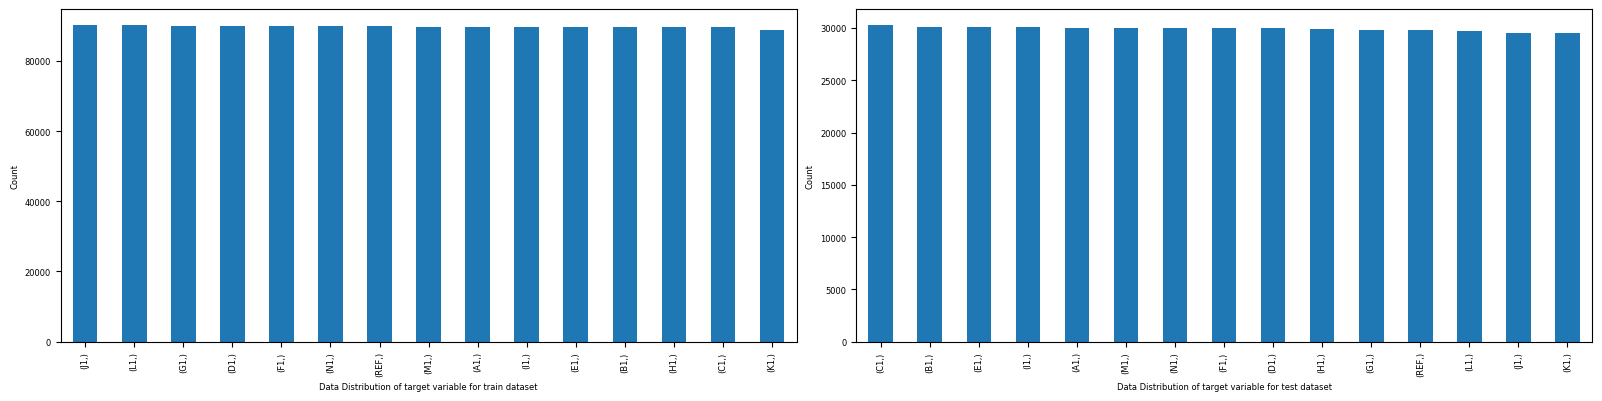

In [409]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [410]:
train_ex = train_set.copy()

In [16]:
train_ex.info()
# train_ex.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1436488 entries, 1723695 to 172769
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Frequency (GHz)  1436488 non-null  float64
 1   LG (mV)          1436488 non-null  float64
 2   HG (mV)          1436488 non-null  float64
 3   Sample           1436488 non-null  object 
dtypes: float64(3), object(1)
memory usage: 54.8+ MB


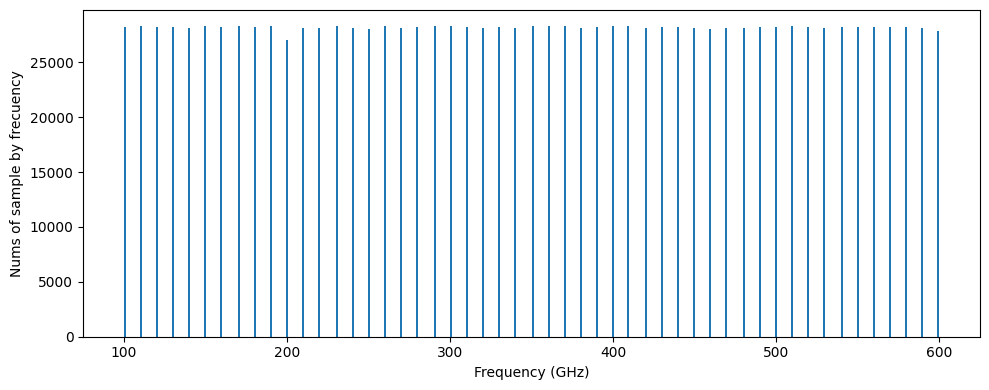

In [18]:

ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
# ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [411]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
data_percentage = (100/(27*(1-test_percentage)))*time_window_s
data_percentage_test = (100/(27*(test_percentage)))*time_window_s

data_percentage = 0
data_percentage_test = 0

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)

# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

#Save the processed data to a CSV file

output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)



Data percentage: 0%
Data percentage test: 0%


In [404]:
print(f"Train set shape: {train_set_test.shape}")
print(f"Test set shape: {test_set_test.shape}")
print(train_set_test.head())
print(test_set.shape)


Train set shape: (24365, 103)
Test set shape: (7726, 103)
   100.0 HG (mV)  100.0 LG (mV)  110.0 HG (mV)  110.0 LG (mV)  120.0 HG (mV)  \
0      -0.976610      57.990481      -0.488353      -2.930045      -0.488329   
1       0.488305      35.038456       0.366282      65.071420       0.244164   
2      -0.976682      62.995972      -0.488329      42.973995      -1.098752   
3      -0.366282      18.923210      -0.366306      13.551459      -0.244212   
4      -0.488305      48.834087       0.000024      14.894396      -1.220894   

   120.0 LG (mV)  130.0 HG (mV)  130.0 LG (mV)  140.0 HG (mV)  140.0 LG (mV)  \
0      89.732639      -1.587105      25.637895      -0.854588      90.587230   
1     126.358208      -0.366306      34.305945       0.122094      90.587229   
2      84.482975       0.122023      39.311439       0.244141      82.407519   
3     143.083884       0.244188      52.984983       0.488353      97.912341   
4     114.882198      -0.976658      36.381394      -0.854564

### Principal Component Analysis

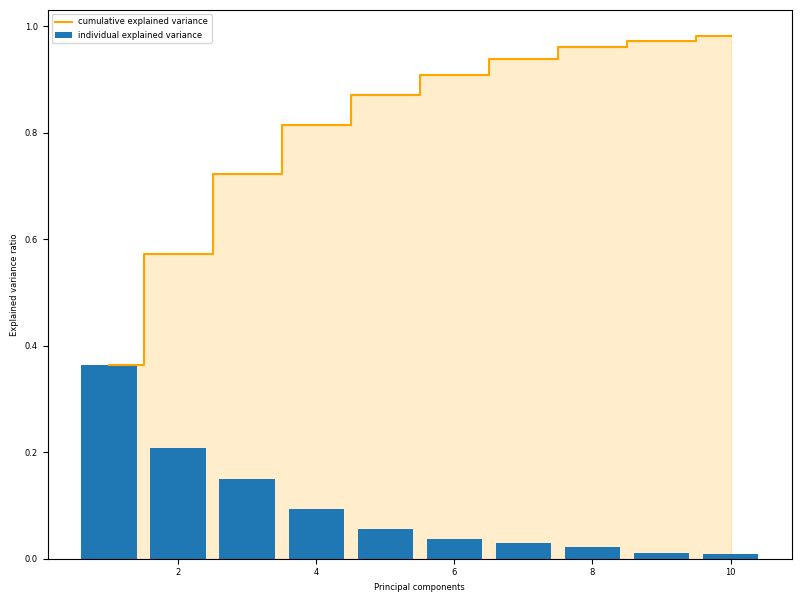

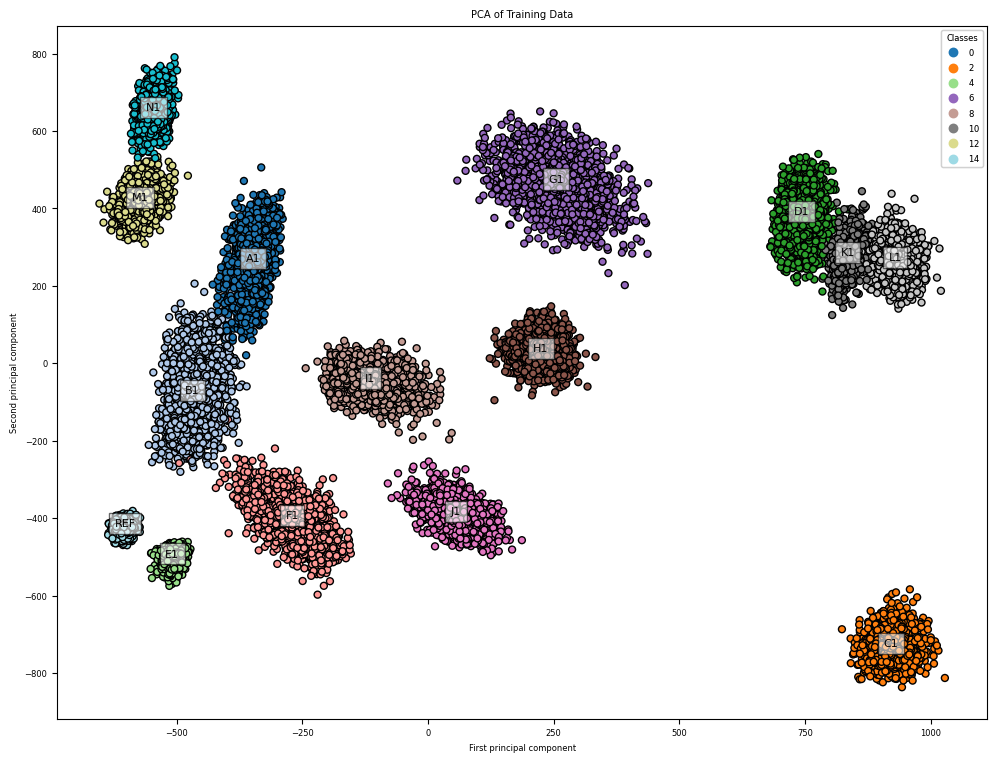

Component 1:
320.0 HG (mV)    0.468938
310.0 HG (mV)    0.457746
330.0 HG (mV)    0.352399
250.0 HG (mV)    0.340057
200.0 HG (mV)    0.108626
230.0 HG (mV)    0.086511
300.0 HG (mV)    0.052309
270.0 HG (mV)    0.051033
280.0 HG (mV)    0.020628
100.0 LG (mV)    0.003971
Name: 0, dtype: float64 

340.0 HG (mV)   -0.242074
390.0 HG (mV)   -0.238891
350.0 HG (mV)   -0.212619
400.0 HG (mV)   -0.160574
370.0 HG (mV)   -0.157264
410.0 HG (mV)   -0.156857
380.0 HG (mV)   -0.155509
430.0 HG (mV)   -0.094100
440.0 HG (mV)   -0.092572
450.0 HG (mV)   -0.092139
Name: 0, dtype: float64 

Component 2:
230.0 HG (mV)    0.775793
410.0 HG (mV)    0.081607
310.0 HG (mV)    0.070562
200.0 HG (mV)    0.058124
460.0 HG (mV)    0.042073
300.0 HG (mV)    0.030544
270.0 HG (mV)    0.029714
120.0 LG (mV)    0.018044
370.0 HG (mV)    0.016917
590.0 HG (mV)    0.015226
Name: 1, dtype: float64 

290.0 HG (mV)   -0.433415
250.0 HG (mV)   -0.316319
330.0 HG (mV)   -0.166654
350.0 HG (mV)   -0.160905
360.0 HG (mV

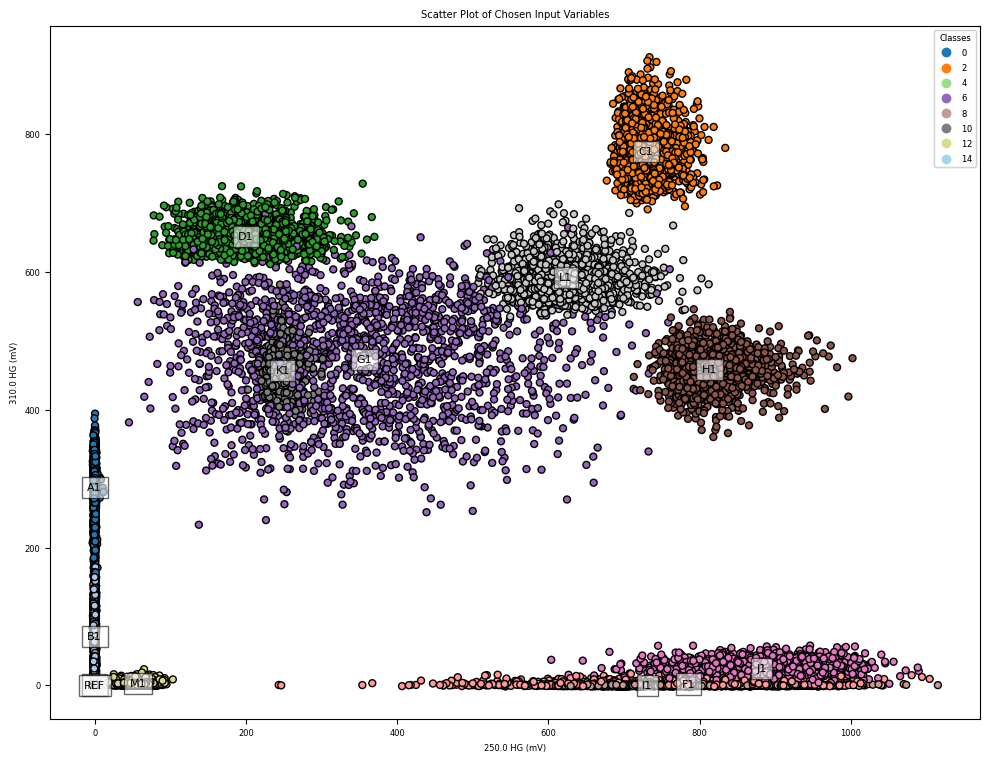

In [422]:
# Apply PCA
n_components =10
pca = PCA(n_components)  # Reduce to 2 components for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_pca = y_train

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.step(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color='orange')
plt.fill_between(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), step='mid', alpha=0.2, color='orange')
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=1.0, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### VISUALIZATION ###
# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_pca, cmap = 'tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 10
for i, label in enumerate(labels):
    plt.text(X_train_pca[y_pca == i, 0].mean() , X_train_pca[y_pca == i, 1].mean() + offset, label,
             ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))


plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA of Training Data')


plt.show()


# Show how the principal components are related to the original features
# Create a DataFrame with the PCA components
components = pd.DataFrame(pca.components_, columns=X_train.columns)
# Transpose the DataFrame
components = components.T
# Display the highest and lowest n variables of the first 3 components
n= 10
for i in range(n_components):
    print(f"Component {i+1}:")
    print(components[i].nlargest(n), '\n')
    print(components[i].nsmallest(n), '\n')


## NON PCA VISUALIZATION ##
# Choose specific variables for visualization
var1 = '250.0 HG (mV)'
var2 = '310.0 HG (mV)'
# var2 = '320.0 HG (mV) std deviation'


# Plot the chosen input variables for visualization
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train[var1], X_train[var2], c=y_train, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0
unique_labels = np.unique(y_train)
for i, label in enumerate(unique_labels):
    plt.text(X_train[y_train == label][var1].mean(), X_train[y_train == label][var2].mean() + offset, 
             labels[label], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()





In [423]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

input_size, output_size

# print(f'input_size: {input_size}, output_size: {output_size}')
# print(X_train, y_train)

(102, 15)